# Poker Monster
by Henry Daum

This is the game engine and deep reinforcement learning AI for my card game Poker Monster.

(The following code cell initializes some basic variables)

In [298]:
"""In order to implement more cards, here is what's needed:
Some cards create rule changes that can be done in the is_legal method of the action class.
Some cards specifically target the hero or monster, which can be done in the action class.
Some cards have special effects that can be implemented as a Card subclass.
Some cards need additional information to play (are multi-step), which can be handled using 
game phases and writing additional information to 'the cache' in each phase, as well as
using action subclasses."""

# This is the data for the cards in the game.
hero_card_data = [
    (3, "Awakening", "hero", 3, "short", None, "Flip over your power cards, revealing them. Any that are short cards return to your hand. Any that are long cards stay on the board face-up."),
    (3, "Healthy Eating", "hero", 2, "short", None, "Draw a card. You can play an extra power card this turn."),
    (2, "The Sun", "hero", 2, "long", 2, "The Monster can only play 1 face-up card per turn."),
    (2, "The Moon", "hero", 3, "long", 2, "The Monster can't play any more power cards."),
    (2, "A Playful Pixie", "hero", 4, "long", 4, "At the start of your turn, you get to steal the top card of the Monster's deck. (Repeat this every turn.)"),
    (2, "A Pearlescent Dragon", "hero", 5, "long", 4, "At the start of your turn, you get to steal 5 health from the Monster. (Repeat this every turn.)"),
    (1, "Last Stand", "hero", 0, "short", None, "Shuffle 3 other cards from your discard pile into your deck. Until your next turn starts, your health can't reach 0 (damage that would put it to less than 1 puts it to 1 instead.)"),
    (2, "Reconsider", "hero", 1, "short", None, "Look at the top 3 cards of your deck, and put them back in any order you choose."),
    (3, "Noble Sacrifice", "hero", 1, "short", None, "As an additional cost to play this card, you must sacrifice a long card. Look at your opponent's hand and discard a card from it."),
]
"""The data format is: quantity, name, owner, power_cost, card_type, health, card text"""

monster_card_data = [
    (3, "Monster's Pawn", "monster", 3, "long", 3, "Your first short card each turn costs no power to play."),
    (1, "Power Trip", "monster", 0, "short", None, "Gain +2 power (for this turn only)."),
    (3, "Go All In", "monster", 3, "short", None, "Choose a player. They draw 3 cards and lose 5 health."),
    (1, "Fold", "monster", 0, "short", None, "Choose a player. They gain 4 health and discard the top 2 cards of their deck."),
    (3, "Poker Face", "monster", 2, "short", None, "Deal 4 damage (to any player or long card)."),
    (3, "Cheap Shot", "monster", 2, "short", None, "Deal 2 damage (to any player or long card). Draw a card."),
    (1, "The 'Ol Switcheroo", "monster", 3, "short", None, "The Hero and the Monster switch health."),
    (2, "Ultimatum", "monster", 1, "short", None, "Search your deck for any two cards you want with different names and reveal them. Your opponent chooses one of them. Put the chosen card into your hand, and shuffle the other back into your deck."),
    (3, "Peek", "monster", 1, "short", None, "Look at the top 2 cards of your deck and put one into your hand, and the other on the bottom of your deck."),
]

# New card, used to increase the difficulty:
mind_control_data = (1, "Mind Control", "either", 4, "short", None, "You control your opponent's next turn. (This card cannot be discarded or stolen.)")

card_data = hero_card_data + monster_card_data + [mind_control_data]  # Comment out '+ [mind_control_data]' to remove it from the game

num_cards = 0

long_cards_vector = []  # List of the uids of just long cards

uid = 0  # This thing is to get num_cards and the long_cards_vector. (Overlaps with build_deck in utils, but that's ok for now.)
for i in range(len(card_data)):
    quantity, name, owner, power_cost, card_type, health, card_text = card_data[i]
    for j in range(quantity):
        num_cards += 1
        if card_type == "long":
            long_cards_vector.append(uid)
        uid += 1

num_actions = num_cards + 2  # +2 for end turn and cancel, computers can't cancel so for them it's num_cards + 1

# Game phases. The strings can be edited to say anything and the game will run the same.
PHASE_AWAITING_INPUT = "Awaiting input."
PHASE_PLAYING_SELECTED_CARD = "Choosing how to play selected card."
PHASE_VIEWING_CARD_INFO = "Viewing card info."
PHASE_SELECTING_GRAVEYARD_CARD = "Choosing card from graveyard."
PHASE_REORDERING_DECK_TOP3 = "Reordering top 3 cards of deck. First card chosen goes on top, second card below that, and third is last."
PHASE_SACRIFICING_LONG_CARD = "Choosing a Noble Sacrifice."
PHASE_DISCARDING_CARD_FROM_OPP_HAND = "Looking at opponent's hand and discarding a card from it."
PHASE_CHOOSING_GO_ALL_IN_TARGET = "Choosing Go All In target."
PHASE_CHOOSING_FOLD_TARGET = "Choosing Fold target."
PHASE_CHOOSING_POKER_FACE_TARGET = "Choosing Poker Face target."
PHASE_CHOOSING_CHEAP_SHOT_TARGET = "Choosing Cheap Shot target."
PHASE_CHOOSING_ULTIMATUM_CARD = "Choosing an Ultimatum card from deck."
PHASE_OPP_CHOOSING_FROM_ULTIMATUM = "Choosing from Ultimatum. Chosen card goes into opp hand, other is shuffled into their deck."
PHASE_CHOOSING_FROM_DECK_TOP2 = "Choosing from Peek."
PHASE_HAND_FULL_DISCARDING_CARD = "Hand full, discarding card."

game_phases = [
    PHASE_AWAITING_INPUT,
    PHASE_PLAYING_SELECTED_CARD,
    PHASE_VIEWING_CARD_INFO,
    PHASE_SELECTING_GRAVEYARD_CARD,
    PHASE_REORDERING_DECK_TOP3,
    PHASE_SACRIFICING_LONG_CARD,
    PHASE_DISCARDING_CARD_FROM_OPP_HAND,
    PHASE_CHOOSING_GO_ALL_IN_TARGET,
    PHASE_CHOOSING_FOLD_TARGET,
    PHASE_CHOOSING_POKER_FACE_TARGET,
    PHASE_CHOOSING_CHEAP_SHOT_TARGET,
    PHASE_CHOOSING_ULTIMATUM_CARD,
    PHASE_OPP_CHOOSING_FROM_ULTIMATUM,
    PHASE_CHOOSING_FROM_DECK_TOP2,
    PHASE_HAND_FULL_DISCARDING_CARD
]

ERROR_ENEMY_HAS_THE_SUN = "Enemy has The Sun, you can't play more than one card per turn."
ERROR_ENEMY_HAS_THE_MOON = "Enemy has The Moon, you can't play power cards."
ERROR_INVALID_SELECTION = "Invalid selection."
ERROR_CANT_PLAY_ANOTHER_POWER_CARD = "You can't play another power card this turn."
ERROR_NOT_ENOUGH_POWER = "Not enough power to play this card."
ERROR_NO_SACRIFICE = "As an additional cost to play this card, you must sacrifice a long card."
ERROR_MUST_PICK_DIFFERENT_CARD = "Can't pick the same card twice."
ERROR_MUST_HAVE_DIFFERENT_NAME = "Card must have a different name."
ERROR_NO_FURTHER_MOVES = "No further moves available with this card."
ERROR_COMPUTERS_CANT_DO = "Computers can't do this action."  # Canceling and seeing card info are QOL features for people, not computers
ERROR_ACTION_WITHELD_FROM_AI = "This action is witheld from AIs since it would harm their strategy"  # These are like automatic reflexes for the AI - things not to do that would harm 

## The Card Class

The Card Class is the first of the four major classes for the game engine code: Card, Player, GameState, and Action. Since this is a turn-based game, the interactions are very cyclical, iterative, and recursive. Because of this, the code was very tricky to make, as any small mistake becomes amplified with every following turn. However, it now has (I think) no bugs (but you never know... bugs are pesky).

Anyway, the Card Class is in charge of being a sort of storage container for card information, like the card's name (For example, "Noble Sacrifice"), card_id (there are 40 cards in the game), unique id, or uid (there are 18 non-duplicate cards), card type (short or long), and so on.

There are also different Card subclasses for each of the different unique cards. These subclasses make changes to the GameState based on what the card does (for example, Power Trip gives you 2 power), and are called on by the Action class. The actual function that does this is the effect() function, which is different for every card since they have different effects.

In [ ]:
class Card:
    def __init__(self, name, card_id, uid, owner, card_type, power_cost, health, card_text):
        # The smallest unit of gameplay.
        self.name = name
        self.card_id = card_id
        self.uid = uid  # unique identifier (duplicates have different uids)
        self.owner = owner  # "hero" or "monster"; can change by stealing with A Playful Pixie; this info will need to be shown to an AI
        self.card_type = card_type  # "short" or "long"
        self.power_cost = power_cost
        self.health = health
        self.starting_health = health  # Used to reset health after a card dies so it can be played again.
        self.card_text = card_text  # Will be displayed

    def __eq__(self, other):
        if not isinstance(other, Card):
            return NotImplemented
        return self.uid == other.uid

    def effect(self, gs) -> None:
        # Changes the game state based on the card's effect. 
        # Every effect has its own subclass.
        raise NotImplementedError("Subclass must implement effect()")

    def to_dict(self):
        # Encode Card into a dictionary that HTML can use
        image_filename = f"images/{self.name.replace(' ', '_')}.png"

        data = {
            "name": self.name,
            "card_id": self.card_id,
            "uid": self.uid,
            "owner": self.owner,
            "card_type": self.card_type,
            "power_cost": self.power_cost,
            "health": self.health,
            "starting_health": self.starting_health,
            "card_text": self.card_text,
            "image_filename": image_filename  # To display images on the website
        }
        return data

    @classmethod
    def from_dict(cls, data):
        # Take the dictionary and use its values to call create_card (turns HTML into a Card)
        card =  create_card(
            name=data["name"],
            card_id=data["card_id"],
            uid=data["uid"],
            owner=data["owner"],
            card_type=data["card_type"],
            power_cost=data["power_cost"],
            health=data["health"],
            card_text=data["card_text"]
        )
        card.starting_health = data["starting_health"]
        return card

class Awakening(Card):
    def effect(self, gs):
        #print("Playing Awakening")
        flipped_power_cards = gs.me.power_cards
        gs.me.power_cards = []  # reset power cards
        for power_card in flipped_power_cards:
            if power_card.card_type == "short":
                gs.me.hand.append(power_card)
            if power_card.card_type == "long":
                gs.me.battlefield.append(power_card)

class HealthyEating(Card):
    def effect(self, gs):
        #print("Playing Healthy Eating")
        gs.me.draw()
        gs.me.power_plays_left += 1

# No subclasses for The Sun and The Moon

class APLayfulPixie(Card):
    def effect(self, gs):
        #print("A Playful Pixie effect triggered")
        if gs.opp.deck:
            card = gs.opp.deck.pop(0)
            card.owner = gs.me.name
            gs.me.hand.append(card)

class APearlescentDragon(Card):
    def effect(self, gs):
        #print("A Pearlescent Dragon effect triggered")
        gs.opp.health -= 5
        gs.me.health += 5

class LastStand(Card):
    # Needs to work with all graveyard conditions
    def effect(self, gs):
        #print("Playing Last Stand")
        selected_cards = gs.cache[1:]  # If there are no selected cards, gs.cache[1:] returns an empty list
        for card in selected_cards:  # These cards will be taken out of the graveyard and shuffled into the deck
            gs.me.graveyard.remove(card)
            gs.me.deck.append(card)
        gs.me.shuffle()
        gs.me.last_stand_buff = True
        #print("Last Stand buff granted")

class Reconsider(Card):
    def effect(self, gs):
        #print("Playing Reconsider")
        cards_in_new_order = gs.cache [1:]  # If there are fewer than 3 cards left in the deck, this will return that many cards
        # Reinstate deck
        gs.me.deck = gs.me.deck[3:]  # Removes top 3 cards of deck (or all if there's 3 or less cards remaining)
        for card in reversed(cards_in_new_order):
            gs.me.deck.insert(0, card)  # First card chosen goes first, last card chosen goes last

class NobleSacrifice(Card):
    def effect(self, gs):
        #print("Playing Noble Sacrifice")
        sacrifice = gs.cache[1]
        discard = gs.cache[2]  # Can play when opp has no cards in hand, need to code this
        gs.me.battlefield.remove(sacrifice)
        gs.me.graveyard.append(sacrifice)
        if discard:  # If discard exists, discard it.
            gs.opp.discard(discard)

# For the buff to work properly, short_card_played_this_turn must be updated properly
class MonstersPawn(Card):
    def effect(self, gs):
        if not gs.short_card_played_this_turn:
            if gs.me.monsters_pawn_buff != True:
                #print("Monster's Pawn buff granted")  # Don't print this message if you already have the buff
                ...
            gs.me.monsters_pawn_buff = True
        else:
            gs.me.monsters_pawn_buff = False

class PowerTrip(Card):
    def effect(self, gs):
        #print("Playing Power Trip")
        gs.me.power += 2

# No subclasses for Go All In and Fold

class PokerFace(Card):
    def effect(self, gs):
        #print("Playing Poker Face")
        # When Poker Face targets a player, that is handled in the action class.
        target = gs.cache[1]
        target.health -= 4

class CheapShot(Card):
    def effect(self, gs):
        #print("Playing Cheap Shot")
        # When Cheap Shot targets a player, that is handled in the action class.
        target = gs.cache[1]
        target.health -= 2
        gs.me.draw()

class TheOlSwitcheroo(Card):
    def effect(self, gs):
        #print("Playing The 'Ol Switcheroo")
        temp_health = gs.hero.health
        gs.hero.health = gs.monster.health
        gs.monster.health = temp_health

class Ultimatum(Card):
    def effect(self, gs):
        #print("Playing Ultimatum")
        # Note: current turn_priority should be the person playing the card (not the opp)
        ultimatum = gs.cache[1:3]  # Note: this is a list with two cards
        for card in ultimatum:
            if card in gs.me.deck:
                gs.me.deck.remove(card)  # remove ultimatum cards from deck
        opp_selected_card = gs.cache[-1]
        ultimatum.remove(opp_selected_card)
        gs.me.hand.append(opp_selected_card)
        gs.me.deck.append(ultimatum[0])  # Unselected card goes into deck
        gs.me.shuffle()

class Peek(Card):
    def effect(self, gs):
        #print("Playing Peek")
        deck_top2 = gs.me.deck[:2]  # copy top 2 cards of deck
        gs.me.deck = gs.me.deck[2:]  # remove top 2 cards of deck
        selected_card = gs.cache[1]
        gs.me.hand.append(selected_card)  # put selected card into hand
        deck_top2.remove(selected_card)
        gs.me.deck.append(deck_top2[0])  # Put the other card on the bottom.
        # Don't forget to get the index!

class MindControl(Card):
    def effect(self, gs):
        # print("Playing Mind Control")
        gs.opp.player_type = "computer_mind_controlled"

## The Player Class

The Player Class is of two kinds: Hero and Monster. These are the two players, and the player types can be a computer that does random moves, a computer AI that is trained with reinforcement learning (a much tougher opponent), and a person controlled by a real human being. You can match any of these player types against each other.

Each player has several 'zones':
1. Their deck - the cards they draw from over the course of the game and get their starting hand from
2. Their hand - the cards they are able to play (face-up or face-down)
3. Their battlefield - cards they played which have persistent value
4. Their graveyard - cards from the battlefield which have died, or cards they played from their hand that are discarded directly after use
5. Their power cards - cards they played in order to get power, which is used to play face-up cards

All of these zones are populated with various cards (from the Card class), that change throughout the game based on various actions.

The Player Class also keeps track of some slightly less important information, like various buffs, who is going first, their power levels, health, and so on.

The Player Class has various functions that are called on from the Action class with certain actions. That's what all the functions are for.

In [ ]:
class Player:
    def __init__(self, name, deck, player_type="computer_random"):
        # Initializes a player with a name and a deck of cards.
        self.name = name  # "hero " or "monster"
        self.deck = deck
        self.hand = []
        self.battlefield = []
        self.graveyard = []
        self.health = 15  # Starting health
        self.power_cards = []
        self.power = 0  # Used to play cards face up, gained from playing cards face down.
        self.power_plays_left = 1
        self.power_plays_made_this_turn = 0
        self.last_turn_log = []  # For displaying to the opponent, so they can understand what you did last turn
        self.last_stand_buff = False
        self.monsters_pawn_buff = False
        self.going_first = False
        self.player_type = player_type # "person" or "computer" - being a computer means being unable to cancel actions or view card info
        self.starting_player_type = player_type  # For Mind Control
        self.action_number = 0
        self.game_mode = 0  # 0 is normal mode, 1 is "Power Trip" mode - power carries over at the end of the turn. Used to increase difficulty.

    def start_turn(self, gs):
        self.last_turn_log = []
        self.power_plays_left = 1
        self.power_plays_made_this_turn = 0
        self.power += len(self.power_cards)
        self.draw()
        for long_card in self.battlefield:
            if long_card.name not in ["The Moon", "The Sun"]:
                #print("Trying to trigger effect: " + long_card.name)
                long_card.effect(gs)
                if long_card.name != "Monster's Pawn":
                    gs.long_card_value += 0.08  # Gain long-term value for having long cards triggger. 
        if any(long_card.name == "Monster's Pawn" for long_card in self.battlefield):
            gs.long_card_value += 0.08  # No value for having Monster's Pawn trigger more than once
        if self.last_stand_buff:
            self.last_stand_buff = False  # Set this to 0 at the start of one's own turn so that it can be active during opponent's turn
            #print("Last Stand buff wore off")

    def end_turn(self, gs):
        if self.game_mode == 0:  # Reset power if game mode is normal. Else, let it carry over. Simple change.
            self.power = 0
        elif gs.turn_number == 0:
            self.power = 0
        if self.player_type == "computer_mind_controlled":
            self.player_type = self.starting_player_type
            # print("Mind control stopped")
        gs.pass_priority()

    def draw(self, qty=1):
        for i in range(qty):
            # If there are no cards left in the deck, do not draw to prevent an error.
            if self.deck:
                card = self.deck.pop(0)
                self.hand.append(card)

    def mill(self, qty=1):  # Burns cards from the top of the deck
        for i in range(qty):
            if self.deck:
                card = self.deck.pop(0)
                self.graveyard.append(card)

    def shuffle(self):
        from random import shuffle
        shuffle(self.deck)

    def discard(self, card):
        self.hand.remove(card)
        self.graveyard.append(card)

    # Playing a card face down
    def play_power_card(self, gs, card):
        self.last_turn_log.append("Played a power card")
        self.hand.remove(card)
        self.power_cards.append(card)
        self.power_plays_left -= 1
        self.power_plays_made_this_turn += 1
        self.power += 1

    def pay_power_cost(self, gs, card):
        #print("Paying power cost")
        if card.card_type == "short":
            if self.monsters_pawn_buff == True:
                #print("Monster's Pawn buff used")
                self.monsters_pawn_buff = False  # Monster's Pawn buff is used up, and don't have to pay power cost.
            else:
                self.power -= card.power_cost
        if card.card_type == "long":
            self.power -= card.power_cost

    # Playing a card face up, either long or short.
    def play_face_up(self, gs, card, no_effect=False):
        self.last_turn_log.append(f"Played {card.name}")
        # Pass no_effect to play_short_card (and not play_long_card) since only short cards have effects when you play them
        #print("no more info needed")
        #print("playing card face up: " + card.name)
        if card.card_type == "short":
            self.play_short_card(gs, card, no_effect)
            gs.short_card_played_this_turn = True  # For Monster's Pawn
        elif card.card_type == "long":
            self.play_long_card(gs, card)
        gs.card_played_this_turn = True  # For The Sun

    def play_long_card(self, gs, card):
        self.pay_power_cost(gs, card)
        self.hand.remove(card)
        self.battlefield.append(card)

    def play_short_card(self, gs, card, no_effect=False):
        self.pay_power_cost(gs, card)
        self.hand.remove(card)
        if not no_effect:  # This is for TargetHero and TargetMonster actions
            card.effect(gs)
        self.graveyard.append(card)

    def to_dict(self):
        return {
            "name": self.name,
            "health": self.health,
            "power": self.power,
            "power_plays_left": self.power_plays_left,
            "power_plays_made_this_turn": self.power_plays_made_this_turn,
            "last_turn_log": self.last_turn_log,
            "last_stand_buff": self.last_stand_buff,
            "monsters_pawn_buff": self.monsters_pawn_buff,
            "going_first": self.going_first,
            "player_type": self.player_type,
            "action_number": self.action_number,
            "game_mode": self.game_mode,
            
            # Create a list of nested card dictionaries for each card zone
            "hand": [card.to_dict() for card in self.hand],
            "deck": [card.to_dict() for card in self.deck],
            "battlefield": [long_card.to_dict() for long_card in self.battlefield],
            "graveyard": [card.to_dict() for card in self.graveyard],
            "power_cards": [power_card.to_dict() for power_card in self.power_cards],
        }

    @classmethod
    def from_dict(cls, data):
        # Create a new Player instance. Note the empty deck for now.
        player = cls(name=data['name'], deck=[], player_type=data['player_type'])
        
        # Set the simple attributes
        player.health = data["health"]
        player.power = data["power"]
        player.power_plays_left = data["power_plays_left"]
        player.power_plays_made_this_turn = data["power_plays_made_this_turn"]
        player.last_turn_log = data["last_turn_log"]
        player.last_stand_buff = data["last_stand_buff"]
        player.monsters_pawn_buff = data["monsters_pawn_buff"]
        player.going_first = data["going_first"]
        player.player_type = data["player_type"]
        player.action_number = data["action_number"]
        player.game_mode = data["game_mode"]

        # Rebuild the card lists using Card.from_dict()
        player.hand = [Card.from_dict(card_data) for card_data in data["hand"]]
        player.deck = [Card.from_dict(card_data) for card_data in data["deck"]]
        player.battlefield = [Card.from_dict(card_data) for card_data in data["battlefield"]]
        player.graveyard = [Card.from_dict(card_data) for card_data in data["graveyard"]]
        player.power_cards = [Card.from_dict(card_data) for card_data in data["power_cards"]]
        
        return player

## The GameState Class

The GameState class contains all of the game data, including Hero and Monster and their everything (hands, decks, graveyards, power_cards, etc.). The GameState also keeps track of the game_phase and cache, which are needed to execute multi-step actions/cards. The GameState also checks for the winner, manages turn priority, checks for deaths on the battlefield, and is the ultimate source of feedback for the AI. Feedback is the only part of the AI code that you can't just grab off the shelf, but actually need to design with a bit of game understanding. There are four sources of feedback: 
1. Tempo - adressed in the Action class
2. Killer combos - rewards for making cool plays using the cards Awakening and The 'OL Switcheroo
3. Long card value - rewards for keeping your long cards alive
4. Winning or losing the game - this is the largest and most important source of feedback

Critically, the GameState also keeps track of who "me" and the "opp" is using the turn priority. These things are used all over the code, and just refer to which player has turn priority and is making actions.

In [301]:
import math

class GameState:
    def __init__(self, hero, monster, turn_priority=None, game_phase=PHASE_AWAITING_INPUT, cache=[]):
        # Initializes the game state. Contains both players.
        self.hero = hero
        self.monster = monster
        self.turn_priority = turn_priority  # Basically whose turn it is to take an action
        self.game_phase = game_phase
        self.cache = cache  # The cache, similar to Magic: The Gathering's stack
        self.turn_number = 0
        self.winner = None

        self.card_played_this_turn = False  # Flag to track if any card has been played this turn
        self.short_card_played_this_turn = False

        self.tempo = 0  # Updated whenever a player does certain actions, cleared when the next action starts
        self.killer_combo = 0  # Updated whenever a player pulls of an 'Ol Switcheroo combo or Awakening combo
        self.long_card_value = 0  # Updated whenever a long card gets a start-of-turn trigger (updated directly in Player class, under start_turn)

    @property
    def me(self):
        """Returns the current player based on turn priority"""
        return self.hero if self.turn_priority == "hero" else self.monster
    
    @property
    def opp(self):
        """Returns the opponent based on turn priority"""
        return self.monster if self.turn_priority == "hero" else self.hero

    @property
    def uncertainty(self):
        # Uncertainty: This is a useful value for AIs to know - It corresponds to how much hidden information there is.
        return len(self.opp.hand) + len(self.opp.deck) + len(self.opp.power_cards) + len(self.me.deck)
    
    def pass_priority(self):
        """Swaps turn priority between hero and monster."""
        self.turn_priority = "monster" if self.turn_priority == "hero" else "hero"

    def turn_transition(self):
        # Ends one player's turn and starts the other's
        #print(f"Ending {self.me.name}'s turn")
        self.me.end_turn(self)
        # Note that turn priority changes here, so the next player is now the previous opponent.
        self.turn_number += 1
        self.card_played_this_turn = False
        self.short_card_played_this_turn = False  # Make sure this is before start_turn so that Monster's Pawn can trigger. The order here is finnicky.
        #print(f"Starting {self.me.name}'s turn")
        self.me.start_turn(self)

    # Check this after every action
    def check_game_over(self) -> None:
        """Determine winner, if any."""
        monster_win = False
        hero_win = False
    
        # Check Hero loss conditions
        if len(self.hero.deck) == 0:
            monster_win = True
        if self.hero.health < 1:
            if self.hero.last_stand_buff:
                #print("Hero stayed alive using Last Stand buff")
                self.hero.health = 1  # Keeps Hero alive
            else:
                monster_win = True
    
        # Check Monster loss conditions
        if self.monster.health < 1 or len(self.monster.deck) == 0:
            hero_win = True
    
        # Determine final outcome
        if monster_win and hero_win:
            self.winner = "tie"
        elif monster_win:
            self.winner = "monster"
        elif hero_win:
            self.winner = "hero"

    # Check this after every action
    def check_long_card_deaths(self) -> None:
        """Check if any long cards on the battlefield have died."""
        for card in self.hero.battlefield[:]:
            if card.health <= 0:
                self.hero.battlefield.remove(card)
                self.hero.graveyard.append(card)
                card.health = card.starting_health  # Restore to full health after it is in the graveyard
        for card in self.monster.battlefield[:]:
            if card.health <= 0:
                self.monster.battlefield.remove(card)
                self.monster.graveyard.append(card)
                card.health = card.starting_health

    # Update this after every action
    def update_pawn_buff(self):
        for long_card in self.me.battlefield:
            if long_card.name == "Monster's Pawn":
                long_card.effect(self)  # This should trigger the buff

        # Check if all Monster's Pawns have died on a given battlefield, and only then remove the buff
        if not any(long_card.name == "Monster's Pawn" for long_card in self.me.battlefield):
            self.me.monsters_pawn_buff = 0
        if not any(long_card.name == "Monster's Pawn" for long_card in self.opp.battlefield):
            self.opp.monsters_pawn_buff = 0

    def long_term_reward(self, perspective, tempo_weight=1.0):
        # Reward shaping: assigning rewards to help shape learning outcomes. Sort of like school.
        # Initialize rewards. Long-term rewards are only awarded at the end of the game.
        hero_reward = 0
        monster_reward = 0

        # Winning/losing - Provide a reward for winning or losing the game - this is (and has to be) the largest reward/punishment out of any of these
        self.check_game_over()  # This might not be necessary, but doesn't hurt to have it here.
        if self.winner == "hero":
            hero_reward += 1
            monster_reward -= 1

        elif self.winner == "monster":
            monster_reward += 1
            hero_reward -= 1

        # Killer Cccombos: long-term rewards for pulling off difficult combos
        hero_reward += self.killer_combo * tempo_weight
        monster_reward += self.killer_combo * tempo_weight

        # if self.killer_combo:
        #     print(f"KILLER COMBO {self.killer_combo:.2f} {self.me.name}")

        # Long card value: This needs to be a long-term reward so that the reward can reach back and reinforce the actions which led to its occurence (may have been several turns back)
        hero_reward += self.long_card_value * tempo_weight
        monster_reward += self.long_card_value * tempo_weight

        # if self.long_card_value:
        #     print(f"Long card value: {self.long_card_value:.2f} {self.me.name}")

        # Return
        if perspective == "hero":
            return hero_reward
        elif perspective == "monster":
            return monster_reward

    def short_term_reward(self, perspective, tempo_weight=1.0):
        # Short-term rewards are awarded during the entire game, before the game ends.
        # These rewards need to be indicative of a win or loss. There must be some correlation between these things and winning or losing.
        hero_reward = 0
        monster_reward = 0

        # These actions have a smaller gamma, so the reward does not reach back so far. It only reinforces the actions which came immediately before it.

        # Tempo - get rewarded for taking certain actions, such as spending power. These points are awarded in the Actions section of the game engine code.
        if self.turn_priority == "hero":
            hero_reward += (self.tempo / 8) * tempo_weight
        else:
            monster_reward += (self.tempo / 8) * tempo_weight

        # Return
        if perspective == "hero":
            return hero_reward
        elif perspective == "monster":
            return monster_reward

    def to_dict(self):
        # Turns the gs into a dictionary that HTML can read
        return {
            # Call the methods you already wrote for Player
            "hero": self.hero.to_dict(),
            "monster": self.monster.to_dict(),
            
            # Save the simple attributes
            "turn_priority": self.turn_priority,
            "game_phase": self.game_phase,
            "turn_number": self.turn_number,
            "winner": self.winner,

            # Flags:
            "card_played_this_turn": self.card_played_this_turn,
            "short_card_played_this_turn": self.short_card_played_this_turn,

            # Reward data:
            "tempo": self.tempo,
            "killer_combo": self.killer_combo,
            "long_card_value": self.long_card_value,

            # The cache is a list of cards, so we serialize it like other card lists
            "cache": [card.to_dict() for card in self.cache]
        }

    @classmethod
    def from_dict(cls, data):
        # Rebuild the complex objects first
        hero = Player.from_dict(data["hero"])
        monster = Player.from_dict(data["monster"])
        cache = [Card.from_dict(card_data) for card_data in data["cache"]]

        # Create a new GameState instance with the rebuilt players
        gs = cls(
            hero=hero,
            monster=monster,
            turn_priority=data["turn_priority"],
            game_phase=data["game_phase"],
            cache=cache
        )
        
        # Set any remaining attributes
        gs.turn_number = data["turn_number"]
        gs.game_phase = data["game_phase"]
        gs.winner = data["winner"]
        gs.card_played_this_turn = data["card_played_this_turn"]
        gs.short_card_played_this_turn = data["short_card_played_this_turn"]
        gs.tempo = data["tempo"]
        gs.killer_combo = data["killer_combo"]
        gs.long_card_value = data["long_card_value"]
        
        return gs

## The Action Class

The Action class is in charge of directing changes to the Gamestate. There are multiple kinds of actions, and each has their own subclass. Each subclass (sub-action) has three parts:
1. is_legal() - this determines whether a given action is legal and returns with a boolean: True/False, depending. The game engine would break if an illegal action was executed, so this prevents that.
2. execute() - this directs the changes to the Gamestate by changing the game phase, adding cards to the cache, and executing cards face-up or face-down (among other things).
3. get_tempo() - if is_legal is like the "hard rules" of what can and cannot be done, get_tempo is like the soft rules which define a fuzzy boundary for the AI to follow. It is a form of feedback - positive, negative, or neutral - for every action.

All three of these functions are combined in the enact() function, which checks if an action is legal, gets the tempo, and then executes if it is legal. After a card is fully resolved, the turn ends, or an action is cancelled, the reset() function is called which empties the cache and resets the game_phase.

I wrote is_legal() based on the rules of the game, and I wrote get_tempo based on *what I believe* is the optimal strategy for the game. (This means get_tempo might be slightly biased, which could lead to the AI being slightly biased.) Thankfully, it doesn't need to be perfect - just enough to help the AI learn. 

In [ ]:
from typing import Tuple, Optional

class Action(object):
    def __init__(self, gs, action_id):
        # The largest unit of gameplay.
        self.gs = gs
        self.action_id = action_id  # Int from 0 to num_actions - 1. Corresponds to various action types. Each subclass is an action type.

    def is_legal(self) -> Tuple[bool, Optional[str]]:
        # Check if the action is legal. Returns a tuple of (is_legal, reason). If True, reason is None.
        raise NotImplementedError("Subclass must implement is_legal()")

    def execute(self) -> None:
        # Execute the action, changing the gamestate.
        raise NotImplementedError("Subclass must implement is_legal()")

    def get_tempo(self) -> int:
        # Every single action has a tempo: positive, negative, or neutral. This tempo is used as feedback for the AI.
        raise NotImplementedError("Subclass must implement get_tempo()")

    def enact(self) -> Tuple[bool, Optional[str]]:
        # Enact = if it is legal, update some rewards, and then execute the action
        legal, reason = self.is_legal()
        # Reset tempo, killer_combo, and long_card_value, *before* the action is executed. This ensures the rewards only show up for a single time step.
        self.gs.tempo = 0
        self.gs.killer_combo = 0
        self.gs.long_card_value = 0
        self.gs.me.action_number += 1
        if legal:
            #print("Action is legal")
            # Get tempo - do before executing so that the effects don't change things first
            self.get_tempo()  # Also updates Killer Combo (the last, long_card_value, is updated in start_turn() in the Player class)
            try:
                self.execute()
            except:
                print("The action had an error while executing.")
                print(f"Action Class: {type(self).__name__}")
                print(f"Action ID: {self.action_id} - Game Phase: {self.gs.game_phase}")
                print(f"cache: {[card.name for card in self.gs.cache]}")
                raise TypeError
            # Do these after every action
            self.gs.update_pawn_buff()
            self.gs.check_long_card_deaths()
            self.gs.check_game_over()
        else:
            #print("Action is not legal")
            ...
        return legal, reason

    def predict_tempo(self) -> int:
        # Returns what the tempo + killer combo is for an action - this does not permanently change the gamestate at all. This can be done anytime.
        starting_tempo = self.gs.tempo
        starting_killer_combo = self.gs.killer_combo
        self.gs.tempo = 0  # Blank slate
        tempo = self.get_tempo()  # Get tempo, which also changes the gamestate. Includes killer_combo.
        self.gs.tempo = starting_tempo  # Revert changes
        self.gs.killer_combo = starting_killer_combo
        return tempo

    # Reset the cache after resolving a given action.
    def reset(self):
        self.gs.cache = []
        self.gs.game_phase = PHASE_AWAITING_INPUT
        #print("Cleared cache")

# Does not represent a valid action, but is used to handle errors.
class InvalidAction(Action):
    def is_legal(self):
        return False, ERROR_INVALID_SELECTION
    
    def execute(self):
        raise ValueError("Invalid action taken")

    def get_tempo(self):
        self.gs.tempo -= 1  # This will never happen, but it's fine.
        return self.gs.tempo

# For cards that target the hero directly.
class TargetHero(Action):
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.resolving_card = self.gs.cache[0]

    def is_legal(self):
        return True, None
    
    def execute(self):
        if self.resolving_card.name == "Go All In":
            #print("Playing Go All In")
            self.gs.hero.health -= 5
            self.gs.hero.draw(3)
        
        elif self.resolving_card.name == "Fold":
            #print("Playing Fold")
            self.gs.hero.health += 4
            self.gs.hero.mill(2)
        
        elif self.resolving_card.name == "Poker Face":
            #print("Playing Poker Face")
            self.gs.hero.health -= 4
        
        elif self.resolving_card.name == "Cheap Shot":
            #print("Playing Cheap Shot")
            self.gs.hero.health -= 2
            self.gs.me.draw()
        # For all these cards:
        self.gs.me.play_face_up(self.gs, self.resolving_card, no_effect=True)  # No effect since that was done just above
        self.reset()

    def get_tempo(self):
        if self.resolving_card.name in ["Poker Face", "Cheap Shot"] and self.gs.me.name == "monster":
            if any(card.name == "The 'Ol Switcheroo" for card in self.gs.me.hand):
                self.gs.tempo += 0  # If you are targeting the Hero with these cards, you may want to wait until after you play The 'Ol Switcheroo, otherwise you don't get the benefit of the Switcheroo
            else:
                self.gs.tempo += 1  # Usually good to damage opponent unless Switcheroo is in your hand
        elif self.resolving_card.name in ["Poker Face", "Cheap Shot"] and self.gs.me.name == "hero":
            self.gs.tempo -= 1  # Don't target yourself
        if self.resolving_card.name == "Go All In" and self.gs.me.name == "monster":
            if any(card.name == "The 'Ol Switcheroo" for card in self.gs.me.hand):
                self.gs.tempo += 0  # You may want to target yourself instead, but it's not bad to target the Hero here
            else:
                self.gs.tempo += 1  # It's good to go hard on opponent if no Switcheroo in hand
        elif self.resolving_card.name == "Go All In" and self.gs.me.name == "hero":
            self.gs.tempo -= 2  # Don't target yourself ever with this if you are the Hero
        if self.resolving_card.name == "Fold" and self.gs.me.name == "monster":
            if any(card.name == "The 'Ol Switcheroo" for card in self.gs.me.hand):
                if self.gs.opp.health + 4 > self.gs.me.health:
                    self.gs.tempo += 2  # Great play, since you can reverse the health gain (+4) with the Switcheroo
                else:
                    self.gs.tempo += 1
            else:
                self.gs.tempo += 0  # Not always great, since you heal the opponent, which makes a damage kill harder to accomplish
        elif self.resolving_card.name == "Fold" and self.gs.me.name == "hero":
            self.gs.tempo -= 1  # Don't target yourself with this
        # These are for trying to teach the AI to clear out long cards:
        if self.resolving_card.name == "Poker Face" and any(card.name in ["A Playful Pixie", "A Pearlescent Dragon", "Monster's Pawn"] for card in self.gs.opp.battlefield):
            self.gs.tempo -= 1  # You should not target your opponent's face if your opponent has a threatening long card you could kill instead
        elif self.resolving_card.name == "Cheap Shot" and any(card.name in ["The Sun", "The Moon"] for card in self.gs.opp.battlefield):
            self.gs.tempo -= 1  # You should not target face if your opponent has a great target for it
        if self.gs.opp.health <= 5 and self.resolving_card.name != "Fold" and self.gs.me.name == "monster":
            self.gs.tempo += 1  # Bonus for going for lethal on Hero if you are the Monster
        return self.gs.tempo

# For cards that target the monster directly. Mirrors TargetHero.
class TargetMonster(Action):
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.resolving_card = self.gs.cache[0]

    def is_legal(self):
        return True, None
    
    def execute(self):
        if self.resolving_card.name == "Go All In":
            #print("Playing Go All In")
            self.gs.monster.health -= 5
            self.gs.monster.draw(3)
        
        elif self.resolving_card.name == "Fold":
            #print("Playing Fold")
            self.gs.monster.health += 4
            self.gs.monster.mill(2)
        
        elif self.resolving_card.name == "Poker Face":
            #print("Playing Poker Face")
            self.gs.monster.health -= 4
        
        elif self.resolving_card.name == "Cheap Shot":
            #print("Playing Cheap Shot")
            self.gs.monster.health -= 2
            self.gs.me.draw()
        # For all these cards:
        self.gs.me.play_face_up(self.gs, self.resolving_card, no_effect=True)  # No effect since that was done just above
        self.reset()

    def get_tempo(self):
        if self.resolving_card.name in ["Poker Face", "Cheap Shot"] and self.gs.me.name == "monster":
            self.gs.tempo -= 2  # You shouldn't damage yourself with these cards in 99.999% of situations
        elif self.resolving_card.name in ["Poker Face", "Cheap Shot"] and self.gs.me.name == "hero":
            self.gs.tempo += 1  # It's fine to damage the opponent with these when you are the Hero (so long as you have enough cards in deck if you are playing Cheap Shot)
            if self.resolving_card.name == "Cheap Shot" and len(self.gs.me.deck) <= 4:
                self.gs.tempo -= 1
        if self.resolving_card.name == "Go All In" and self.gs.me.name == "monster":
            if any(card.name == "A Pearlescent Dragon" for card in self.gs.opp.battlefield):
                self.gs.tempo -= 1  # This takes you dangerously low and can kill you
            elif any(card.name == "The 'Ol Switcheroo" for card in self.gs.me.deck):
                self.gs.tempo += 0  # It's fine to damage yourself with this card, since you draw 3 cards and can reverse the damage (later) with The 'Ol Switcheroo
            elif any(card.name == "The 'Ol Switcheroo" for card in self.gs.me.hand):
                self.gs.tempo += 1  # If you already have the other piece of the combo, you get an extra point
            else:
                self.gs.tempo += 0  # You probably shouldn't do this, but drawing 3 cards can be good
            if self.gs.me.health <= 5 or len(self.gs.me.deck) <= 3:
                self.gs.tempo -= 1  # This kills you
        elif self.resolving_card.name == "Go All In" and self.gs.me.name == "hero":
            self.gs.tempo += 2  # You should always target the Monster with this card if you have it and you are the Hero, since in almost all situations you won't have The 'Ol Switcheroo
        if self.resolving_card.name == "Fold" and self.gs.me.name == "monster":
            self.gs.tempo -= 1  # You shouldn't do this in 99% of situations
        elif self.resolving_card.name == "Fold" and self.gs.me.name == "hero":
            self.gs.tempo += 1  # Fine to do
        # These are for trying to teach the AI to clear out long cards:
        if self.resolving_card.name == "Poker Face" and any(card.name in ["A Playful Pixie", "A Pearlescent Dragon", "Monster's Pawn"] for card in self.gs.opp.battlefield):
            self.gs.tempo -= 1  # You should not target your opponent's face if your opponent has a threatening long card you could kill instead
        elif self.resolving_card.name == "Cheap Shot" and any(card.name in ["The Sun", "The Moon"] for card in self.gs.opp.battlefield):
            self.gs.tempo -= 1  # You should not target face if your opponent has a great target for it
        if self.gs.opp.health <= 5 and self.resolving_card.name != "Fold" and self.gs.me.name == "hero":
            self.gs.tempo += 1  # Bonus for going for lethal on Monster if you are the Hero
        return self.gs.tempo

class GetCardInfo(Action):
    def is_legal(self):
        if self.gs.me.player_type.startswith("computer"):
            return False, ERROR_COMPUTERS_CANT_DO
        return True, None
    
    def execute(self):
        # Display card info
        self.gs.game_phase = PHASE_VIEWING_CARD_INFO  # You can read card text and cancel

    def get_tempo(self):
        self.gs.tempo += 0  # Doesn't affect the game
        return self.gs.tempo

# To cancel the current action and go back.
class Cancel(Action):
    def is_legal(self):
        if self.gs.me.player_type.startswith("computer"):
            return False, ERROR_COMPUTERS_CANT_DO
        return True, None
    
    def execute(self):
        self.reset()  # Just resets the cache. No gamestate changes; all that's lost is information.

    def get_tempo(self):
        self.gs.tempo += 0  # No effect on the game itself, hence 0 tempo
        return self.gs.tempo

# To end the turn. This also starts the next turn for the opponent.
class EndTurn(Action):
    def is_legal(self):
        return True, None  # If the option is available, it is always legal.
    
    def execute(self):        
        if len(self.gs.me.hand) > 5:  # check if hand is over maximum hand size (5)
            self.gs.game_phase = PHASE_HAND_FULL_DISCARDING_CARD
        else:
            self.reset()
            self.gs.turn_transition()

    def get_tempo(self):
        if self.gs.me.power:
            self.gs.tempo -= 1  # You shouldn't end your turn without spending all your power
        if len(self.gs.me.power_cards) < 3:
            if self.gs.me.power_plays_left and len(self.gs.me.hand) != 0:
                self.gs.tempo -= 1  # If you have less than 3 power cards and can play another power card, you shouldn't end the turn without playing the dang power card
        if self.gs.opp.battlefield:
            if any(card.name in ["Poker Face", "Cheap Shot"] for card in self.gs.me.hand) and self.gs.me.power >= 2:
                self.gs.tempo -= 1  # You shouldn't end your turn without clearing the opponent's long cards if possible
        if len(self.gs.opp.deck) == 1:
            self.gs.tempo += 1  # This wins you the game
        if len(self.gs.me.hand) > 5:
            self.gs.tempo -= 2  # You shouldn't end your turn with hand size over the maximum limit. Very bad.
        if sum(1 for card in self.gs.me.power_cards if card.card_type == "long") > 1 and self.gs.me.power >= 3:
            self.gs.tempo -= 2  # If you have enough power to play Awakening and you have two or more long cards in your power cards, you shouldn't end the turn without playing it.
        return self.gs.tempo

# To select a card from a list (e.g., hand or battlefield).
# After selecting a card from anywhere, it is added to the cache.
# The bottom card in the cache, index [0], is always the one being played--the resolving card.
class SelectFromHand(Action):
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.card_list = self.gs.me.hand # Search this list for a card with a matching uid.
        self.resolving_card = None # Will store selected card here

    def future_moves_available(self, card) -> Tuple:
        # This is just to simplify the game by showing fewer available moves that don't lead anywhere
        # This enables not letting computers cancel their moves

        # Proposed faster code (reverting the change rather than doing a deepcopy)
        original_phase = self.gs.game_phase
        self.gs.game_phase = PHASE_PLAYING_SELECTED_CARD
        self.gs.cache.append(card)
        test_face_up_action = PlayFaceUp(self.gs, 0)  # 0 = action_id; might not matter?
        test_face_down_action = PlayFaceDown(self.gs, 1)
        test_face_up_action_is_legal, reason = test_face_up_action.is_legal()
        test_face_down_action_is_legal, reason = test_face_down_action.is_legal()
        self.gs.cache.pop()
        self.gs.game_phase = original_phase  # Revert the game phase back to the original state

        # If the face up action is not legal and the face down action is not legal, then it should not be an option -> return False, ERROR_NO_FURTHER_MOVES
        if not test_face_up_action_is_legal and not test_face_down_action_is_legal:
            if self.gs.me.player_type.startswith("computer"):  # Could make it an option for person players to enable this in the future
                return False
        else:
            return True
        
    def is_legal(self):
        # Search card list for a card. If there is a match, action is legal.
        for card in self.card_list:
            if card.uid == self.action_id:  # Card's uid must match the action_id
                # If card does not go anywhere, show as not legal
                if self.future_moves_available(card) == False and self.gs.game_phase != PHASE_HAND_FULL_DISCARDING_CARD:  # Need game phase check since this action is also used for end of turn discard
                    return False, ERROR_NO_FURTHER_MOVES
                self.resolving_card = card
                return True, None  # match found
        return False, ERROR_INVALID_SELECTION  # If no match found, action is illegal.

    def execute(self) -> None:
        self.gs.cache.append(self.resolving_card)  # Add selected card to the cache--always the [0] index
        #print(f"Added card '{self.resolving_card.name}' to cache via '{type(self).__name__}'")
        if self.gs.game_phase == PHASE_AWAITING_INPUT:
            self.gs.game_phase = PHASE_PLAYING_SELECTED_CARD
        
        elif self.gs.game_phase == PHASE_HAND_FULL_DISCARDING_CARD:
            self.gs.me.discard(self.resolving_card)
            #print("Discarded card: " + self.resolving_card.name)
            if len(self.gs.me.hand) <= 5:  # 5 = max hand size
                self.reset()
                self.gs.turn_transition()
            # Else, do nothing -- player has to keep discarding cards until they are below the maximum

    def get_tempo(self):
        if self.gs.game_phase == PHASE_HAND_FULL_DISCARDING_CARD:
            if self.resolving_card.name in ["Go All In", "The 'Ol Switcheroo", "A Pearlescent Dragon", "A Playful Pixie", "Poker Face", "Last Stand"]:
                self.gs.tempo -= 1  # Don't discard these.
            if self.resolving_card.name in ["The 'Ol Switcheroo", "Last Stand"]:
                self.gs.tempo -= 1  # Especially not these, since they can't be replaced
        # These are for trying to teach the AI to clear out long cards:
        if any(card.name == "Poker Face" for card in self.gs.me.hand) and any(card.name in ["A Playful Pixie", "A Pearlescent Dragon"] for card in self.gs.opp.battlefield) and self.gs.me.power >= 2:
            if self.resolving_card.name != "Poker Face":
                self.gs.tempo -= 2  # You should pick Poker Face (to play face-up) if it is in your hand, you have the power, and your opponent has a threatening long card
        if any(card.name == "Cheap Shot" for card in self.gs.me.hand) and any(card.name in ["The Sun", "The Moon"] for card in self.gs.opp.battlefield) and self.gs.me.power >= 2:
            if self.resolving_card.name != "Cheap Shot":
                self.gs.tempo -= 2  # You should pick Cheap Shot (to play face-up) if it is in your hand, you have the power, and your opponent has a great target for it
        # This is for trying to encourage playing Awakening:
        if sum(1 for card in self.gs.me.power_cards if card.card_type == "long") > 1 and self.gs.me.power >= 3:
            if self.resolving_card.name != "Awakening":
                self.gs.tempo -= 1  # If you have enough power to play Awakening and you have two or more long cards in your power cards, you shouldn't end the turn without playing it.
        return self.gs.tempo

# This time, the card list being searched is both battlefields.
# For Poker Face and Cheap Shot
class SelectFromBattlefield(Action):
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.card_list = self.gs.me.battlefield + self.gs.opp.battlefield
        self.target = None  # In this case, a target long card
        self.resolving_card = self.gs.cache[0]

    def is_legal(self):
        # Search card list for a card with a matching uid
        for long_card in self.card_list:
            if long_card.uid == self.action_id:
                self.target = long_card
                if self.gs.me.player_type == "computer_ai":
                    if self.target in self.gs.me.battlefield:
                        return False, ERROR_ACTION_WITHELD_FROM_AI  # The AI should never, ever target their own long card
                return True, None
        return False, ERROR_INVALID_SELECTION  # If no match found
    
    def execute(self) -> None:
        self.gs.cache.append(self.target)  # Add selected target to the cache
        #print(f"Added card '{self.target.name}' to cache via '{type(self).__name__}'")
        self.gs.me.play_face_up(self.gs, self.resolving_card)  
        self.reset()

    def get_tempo(self):
        if self.target in self.gs.me.battlefield:
            self.gs.tempo -= 2 # You shouldn't target your own long cards, ever
        if self.target in self.gs.opp.battlefield:
            self.gs.tempo += 1  # You *should* target the opponent's long cards
        if self.resolving_card.name == "Poker Face" and self.target.name in ["The Sun", "The Moon"]:
            self.gs.tempo -= 0  # This is overkill, but still okay in some situations
            if any(long_card.name in ["A Playful Pixie", "A Pearlescent Dragon"] for long_card in self.gs.opp.battlefield):
                self.gs.tempo -= 2  # You shouldn't target the sun or the moon if you can kill a bigger card
        if self.resolving_card.name == "Cheap Shot" and self.target.name in ["The Sun", "The Moon"]:
            self.gs.tempo += 2  # This is not overkill, Cheap Shot is meant to kill these cards
        if self.resolving_card.name == "Poker Face" and self.target.name in ["A Playful Pixie", "A Pearlescent Dragon", "Monster's Pawn"]:
            self.gs.tempo += 2  # Similarly, Poker Face is definitely meant to kill these cards
        if self.resolving_card.name == "Cheap Shot" and self.target.name in ["A Playful Pixie", "A Pearlescent Dragon"]:
            self.gs.tempo += 1  # Decent play, since you can hit it with another Cheap Shot later to kill it, but that doesn't always happen. Hard to say whether this is neutral or positive tempo.
        return self.gs.tempo

# For Noble Sacrifice
class SelectFromOwnBattlefield(Action):
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.card_list = self.gs.me.battlefield
        self.sacrifice = None  # long card to be sacrificed as payment for Noble Sacrifice

        self.resolving_card = self.gs.cache[0]  # Noble Sacrifice is on the bottom of the stack

    def is_legal(self):
        # Search battlefield for a sacrifice
        for long_card in self.card_list:
            if long_card.uid == self.action_id:
                self.sacrifice = long_card
                return True, None
        return False, ERROR_INVALID_SELECTION  # If no match found

    def execute(self):
        self.gs.cache.append(self.sacrifice)  # Add selected sacrifice to the cache
        #print(f"Added card '{self.sacrifice.name}' to cache via '{type(self).__name__}'")
        # If enemy hand is empty, card can still be played. Just does nothing.
        if len(self.gs.opp.hand) == 0:
            #print("Nothing to discard")
            self.gs.cache.append(None)  # This will be tackled in card class.
            #print(f"Added None to cache via '{type(self).__name__}'")
            self.gs.me.play_face_up(self.gs, self.resolving_card)
            self.reset()        
        else:
            self.gs.game_phase = PHASE_DISCARDING_CARD_FROM_OPP_HAND

    def get_tempo(self):
        if self.sacrifice.name in ["The Sun", "The Moon"]:
            self.gs.tempo += 1  # These are good cards to sacrifice, since they don't cost much
        elif self.sacrifice.name == "A Pearlescent Dragon":
            self.gs.tempo -= 1  # This is not a good sacrifice, since it is powerful, but it has a disadvantage since it weakens you to Switcheroo
        elif self.sacrifice.name == "A Playful Pixie":
            self.gs.tempo -= 2  # This is the worst card to sacrifice, since it has no downsides
        if self.sacrifice.name in ["A Pearlescent Dragon", "A Playful Pixie"] and any(long_card.name in ["The Sun", "The Moon"] for long_card in self.gs.me.battlefield):
            self.gs.tempo -= 1  # If you have The Sun or The Moon, you shouldn't sacrifice a stronger card
        return self.gs.tempo

# For Noble Sacrifice
class SelectFromOppHand(Action):
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.card_list = self.gs.opp.hand
        self.discard = None  # enemy card to discard

        self.resolving_card = self.gs.cache[0]  # Noble Sacrifice is on the bottom of the stack/cache

    def is_legal(self):
        # Search opp hand for discard
        for card in self.card_list:
            if card.uid == self.action_id:
                self.discard = card
                return True, None
        return False, ERROR_INVALID_SELECTION  # If no match found
    
    def execute(self):
        self.gs.cache.append(self.discard)  # Append discard to the cache for next step.
        #print(f"Added card '{self.discard.name}' to cache via '{type(self).__name__}'")
        self.gs.me.play_face_up(self.gs, self.resolving_card)  
        self.reset()

    def get_tempo(self):
        # This needs a little work, to reward the best available discards, not just the best discards in general
        if self.discard.name in ["Peek", "Ultimatum", "Power Trip"]:
            self.gs.tempo -= 1  # These are not good cards to discard, since they are weak
        elif self.discard.name in ["Go All In", "Fold", "Poker Face", "The 'Ol Switcheroo"]:
            self.gs.tempo += 1  # These are good cards to remove, especially Go All In and The 'Ol Switcheroo:
            if self.discard.name in ["Go All In", "The 'Ol Switcheroo"]:
                self.gs.tempo += 1
        else:
            self.gs.tempo += 0  # All other discards are neutral
        return self.gs.tempo

# For Peek
class SelectFromDeckTop2(Action):
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.card_list = self.gs.me.deck[:2]
        self.selected_card = None  # card to put into hand

        self.resolving_card = self.gs.cache[0]  # Noble Sacrifice is on the bottom of the stack/cache

    def is_legal(self):
        # choose card from top2
        for card in self.card_list:
            if card.uid == self.action_id:
                self.selected_card = card
                return True, None
        return False, ERROR_INVALID_SELECTION  # If no match found
    
    def execute(self):
        if len(self.gs.me.deck) == 1:  # You can play this with one card left, but
            self.gs.me.draw()  # you just lose
            self.reset()  # Make sure to reset so the GS is still valid after the game
        else:
            self.gs.cache.append(self.selected_card)  # Append selected card to the cache for next step.
            #print(f"Added card '{self.selected_card.name}' to cache via '{type(self).__name__}'")
            self.gs.me.play_face_up(self.gs, self.resolving_card)  
            self.reset()

    def get_tempo(self):
        if self.selected_card.name in ["Go All In", "Fold", "Poker Face", "The 'Ol Switcheroo", "Cheap Shot", "A Playful Pixie", "A Pearlescent Dragon", "Mind Control"]:
            self.gs.tempo += 1  # These are high priority cards, especially Go All In and The 'Ol Switcheroo
            if self.selected_card.name in ["Go All In", "The 'Ol Switcheroo", "A Playful Pixie", "A Pearlescent Dragon", "Mind Control"]:
                self.gs.tempo += 1
        else:
            self.gs.tempo += 0
        return self.gs.tempo

# For Last Stand
class SelectFromGraveyard(Action):
    # Need to iterate this action class up to three times in order to get information for Last Stand to resolve
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.card_list = self.gs.me.graveyard
        self.selected_card = None  # card to shuffle into deck

        self.resolving_card = self.gs.cache[0]  # In this case, Last Stand
        
        self.previously_selected_cards = self.gs.cache[1:]

    def is_legal(self):
        # choose card from graveyard that *hasn't already been chosen*
        for card in self.card_list:
            if card.uid == self.action_id:  # Test via uid
                if card in self.previously_selected_cards:
                    return False, ERROR_MUST_PICK_DIFFERENT_CARD  # Can't pick the same card twice
                else:
                    self.selected_card = card
                    return True, None
        return False, ERROR_INVALID_SELECTION  # If no match found

    def execute(self):
        # Need escape condition, else this action will loop over and over
        self.gs.cache.append(self.selected_card)  # Append selected card to the cache until cache has 3 cards (not including resolving card)
        #print(f"Added card '{self.selected_card.name}' to cache via '{type(self).__name__}'")
        num_selected_cards = len(self.gs.cache[1:])  # This information is from after the selected card has been added in this step to the cache, unlike the legal check
        if num_selected_cards == 3:  # Full graveyard condition - can nerf to 2
            self.gs.me.play_face_up(self.gs, self.resolving_card)
            self.reset()
        elif num_selected_cards == len(self.gs.me.graveyard):  # Small graveyard condition
            self.gs.me.play_face_up(self.gs, self.resolving_card)
            self.reset()

    def get_tempo(self):
        # Rewards to trigger for card selections:
        if self.selected_card.name in ["Go All In", "Fold", "Poker Face", "The 'Ol Switcheroo", "A Playful Pixie", "A Pearlescent Dragon", "Last Stand", "Noble Sacrifice", "Mind Control"]:
            self.gs.tempo += 1  # These are good targets to shuffle back into the deck
        elif self.selected_card.name in ["Healthy Eating", "Reconsider"]:
            self.gs.tempo -= 1  # Don't do this since you usually don't need more of these and Healthy Eating draws a card, reducing deck size which is not good for the late game
        else:
            self.gs.tempo += 0  # All other cards are neutral
        return self.gs.tempo

# For Ultimatum
class SelectFromDeck(Action):
    # choose two cards from deck with *different names*
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.card_list = self.gs.me.deck
        self.selected_card = None  # Will update if found

        self.resolving_card = self.gs.cache[0]  # Ultimatum

        self.previously_selected_card = None
        if len(self.gs.cache) > 1:
            self.previously_selected_card = self.gs.cache[1]  
        # There are only two cards in an ultimatum, so having only one variable for prev selected cards is fine.

        # Need to test if the deck actually has cards with different names
        first_name = self.card_list[0].name
        self.deck_has_different_names = any(card.name != first_name for card in self.card_list[1:])

    def is_legal(self):
        # This is essentially a stricter test in addition to unique id
        for card in self.card_list:
            if card.uid == self.action_id:
                if self.previously_selected_card:
                    if card.name == self.previously_selected_card.name:
                        # Edge case: deck has two cards left, both with the same name. Allow it.
                        if self.deck_has_different_names:
                            return False, ERROR_MUST_HAVE_DIFFERENT_NAME  # Card must have different name, but can be another "Ultimatum"
                self.selected_card = card
                return True, None
        return False, ERROR_INVALID_SELECTION  # If no match found

    def execute(self):
        self.gs.cache.append(self.selected_card)
        #print(f"Added card '{self.selected_card.name}' to cache via '{type(self).__name__}'")
        num_selected_cards = len(self.gs.cache[1:])  # !Again, this must be calculated again after appending the card.
        if num_selected_cards == 2:  # Need two cards for an ultimatum
            self.gs.game_phase = PHASE_OPP_CHOOSING_FROM_ULTIMATUM
            self.gs.pass_priority()  # Pass priority so opponent can choose from established ultimatum (then pass it back)
            #print("Passed priority")

    def get_tempo(self):
        if self.selected_card.name in ["Go All In", "Fold", "Poker Face", "The 'Ol Switcheroo", "A Playful Pixie", "A Pearlescent Dragon", "Last Stand", "Noble Sacrifice", "Mind Control"]:
            self.gs.tempo += 1  # These are high priority cards, especially Go All In and The 'Ol Switcheroo for Monster and Pixie and Dragon for Hero
            if self.selected_card.name in ["Go All In", "The 'Ol Switcheroo", "A Playful Pixie", "A Pearlescent Dragon", "Mind Control"]:
                self.gs.tempo += 1
        else:
            self.gs.tempo += 0  # All other cards are not good, but not really bad either. You shouldn't be punished for not picking the above cards if they are not available.
        return self.gs.tempo

class SelectFromUltimatum(Action):
    # Opp has priority over this step, which is the opposite of every other card in the game.
    # Only with Ultimatum can the opponent make a decision during your turn.
    # Just need to pass back priority after this.
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        ultimatum = self.gs.cache[1:]  # This is the two cards chosen during the previous two game phases
        self.card_list = ultimatum  # Opponent searches the ultimatum
        self.selected_card = None  # Update if found

        self.resolving_card = self.gs.cache[0]

    def is_legal(self):
        # Similar to other searches
        for card in self.card_list:
            if card.uid == self.action_id:  # Test via uid
                self.selected_card = card
                return True, None
        return False, ERROR_INVALID_SELECTION  # If no match found
    
    def execute(self):
        self.gs.cache.append(self.selected_card)  # Add to cache
        #print(f"Added card '{self.selected_card.name}' to cache via '{type(self).__name__}'")
        self.gs.pass_priority()  # Pass it back before the card is handled in the card subclass
        #print("Passed priority back")
        self.gs.me.play_face_up(self.gs, self.resolving_card)
        self.reset()

    def get_tempo(self):
        if self.selected_card.name in ["Go All In", "Fold", "Poker Face", "The 'Ol Switcheroo", "A Playful Pixie", "A Pearlescent Dragon", "Last Stand", "Noble Sacrifice"]:
            self.gs.tempo -= 1  # These are high priority cards, especially Go All In and The 'Ol Switcheroo for M and yeah like above. The selected card goes into their hand.
            if self.selected_card.name in ["Go All In", "The 'Ol Switcheroo", "A Playful Pixie", "A Pearlescent Dragon"]:
                self.gs.tempo -= 1
        else:
            self.gs.tempo += 0
        return self.gs.tempo

# Reconsider
class SelectFromDeckTop3(Action):
    # Mimics Last Stand
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.card_list = self.gs.me.deck[:3]  # Top 3 cards of deck, mimics Peek
        self.selected_card = None  # card to rearrange

        self.resolving_card = self.gs.cache[0]  # In this case, Reconsider
        
        self.previously_selected_cards = self.gs.cache[1:]

    def is_legal(self):
        for card in self.card_list:
            if card.uid == self.action_id:  # Test via uid
                if card in self.previously_selected_cards:
                    return False, ERROR_MUST_PICK_DIFFERENT_CARD  # Can't pick the same card twice
                else:
                    self.selected_card = card
                    return True, None
        return False, ERROR_INVALID_SELECTION  # If no match found
    
    def execute(self):
        self.gs.cache.append(self.selected_card)  # Append selected card to the cache until cache has 3 cards (not including resolving card)
        #print(f"Added card '{self.selected_card.name}' to cache via '{type(self).__name__}'")
        num_selected_cards = len(self.gs.cache[1:])  # This information is from after the selected card has been added in this step to the cache, unlike the legal check
        if num_selected_cards == 3:  # Full deck condition
            self.gs.me.play_face_up(self.gs, self.resolving_card)
            self.reset()
        elif num_selected_cards == len(self.gs.me.deck):  # Small deck condition
            self.gs.me.play_face_up(self.gs, self.resolving_card)
            self.reset()

    def get_tempo(self):
        if self.selected_card.card_type == "long":  # It's generally good to move long cards to the top, especially Dragon and Pixie
            self.gs.tempo += 1
            if self.selected_card.name in ["A Playful Pixie", "A Pearlescent Dragon", "Mind Control"]:
                self.gs.tempo += 1
        self.gs.tempo += 0  # This is a very low tempo card, but maybe certain choices should be rewarded
        return self.gs.tempo

# To play a long or short card face up.
class PlayFaceUp(Action):
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.resolving_card = self.gs.cache[0]

    def is_legal(self) -> Tuple[bool, Optional[str]]:
        has_enough_power = self.resolving_card.power_cost <= self.gs.me.power
        has_free_short_card = self.gs.me.monsters_pawn_buff
        
        if any(long_card.name == "The Sun" for long_card in self.gs.opp.battlefield) and self.gs.card_played_this_turn:
            return False, ERROR_ENEMY_HAS_THE_SUN  # If enemy has the sun, can't play 2 cards in a turn
        
        elif self.resolving_card.card_type == "short":
            if self.resolving_card.name == "Noble Sacrifice":
                if not self.gs.me.battlefield:
                    return False, ERROR_NO_SACRIFICE  # Must have available sacrifice
                if not self.gs.opp.hand and self.gs.me.player_type == "computer_ai":
                    return False, ERROR_ACTION_WITHELD_FROM_AI  # Helping out the AI
            if self.gs.me.player_type == "computer_ai":
                if self.resolving_card.name == "The 'Ol Switcheroo" and self.gs.me.health >= self.gs.opp.health:
                    return False, ERROR_ACTION_WITHELD_FROM_AI  # Helping out the AI, you would never play Switcheroo if your opponent would benefit from it
                if self.resolving_card.name == "Awakening" and not any(card for card in self.gs.me.power_cards if card.card_type == "long"):
                    return False, ERROR_ACTION_WITHELD_FROM_AI  # The AI should never play Awakening if there aren't any long cards to flip
            if has_free_short_card:
                #print("Free short card available")
                return True, None  # Can play a free short card thanks to Monster's Pawn
            elif not has_enough_power:
                return False, ERROR_NOT_ENOUGH_POWER
        
        elif self.resolving_card.card_type == "long":
            if not has_enough_power:
                return False, ERROR_NOT_ENOUGH_POWER
        return True, None

    # Different game phases follow depending on the card.
    def execute(self) -> None:
        #print("Gathering info needed to play card face up")
        # These cards require extra info to play, which takes extra game phases
        if self.resolving_card.name == "Last Stand":
            if len(self.gs.me.graveyard) == 0:  # Can still play the card with no graveyard, just does nothing except grant the buff
                # Empty graveyard condition
                self.gs.me.play_face_up(self.gs, self.resolving_card)
                self.reset()
            else:
                self.gs.game_phase = PHASE_SELECTING_GRAVEYARD_CARD
        elif self.resolving_card.name == "Reconsider":
            self.gs.game_phase = PHASE_REORDERING_DECK_TOP3
        elif self.resolving_card.name == "Noble Sacrifice":
            self.gs.game_phase = PHASE_SACRIFICING_LONG_CARD
        elif self.resolving_card.name == "Go All In":
            self.gs.game_phase = PHASE_CHOOSING_GO_ALL_IN_TARGET
        elif self.resolving_card.name == "Fold":
            self.gs.game_phase = PHASE_CHOOSING_FOLD_TARGET
        elif self.resolving_card.name == "Poker Face":
            self.gs.game_phase = PHASE_CHOOSING_POKER_FACE_TARGET
        elif self.resolving_card.name == "Cheap Shot":
            self.gs.game_phase = PHASE_CHOOSING_CHEAP_SHOT_TARGET
        elif self.resolving_card.name == "Ultimatum":
            if len(self.gs.me.deck) == 1:  # You can play this with one card left, but
                self.gs.me.draw()  # you just lose
            else: 
                self.gs.game_phase = PHASE_CHOOSING_ULTIMATUM_CARD
        elif self.resolving_card.name == "Peek":
            self.gs.game_phase = PHASE_CHOOSING_FROM_DECK_TOP2
        # Play the card normally if no extra info needed:
        else:
            #print("No info needed")
            self.gs.me.play_face_up(self.gs, self.resolving_card)  
            self.reset()

    def get_tempo(self):
        # Here are the benefits for playing cards face up in specific ways
        # KILLER COMBOS: The 'Ol Switcheroo and Awakening - long lasting rewards that stretch back in time
        if self.resolving_card.name == "The 'Ol Switcheroo":
            health_difference = self.gs.opp.health - self.gs.me.health  # The bigger the health difference, the better
            upper_bound = 15  # 15 health is a reasonable best play to optimize for
            if health_difference <= upper_bound:
                self.gs.killer_combo += health_difference / upper_bound
            elif health_difference > upper_bound:
                self.gs.killer_combo += upper_bound / upper_bound  # +1 - worth as much as winning the game, actually
        elif self.resolving_card.name == "Awakening":
            cumulative_power = sum(power_card.power_cost for power_card in self.gs.me.power_cards if power_card.card_type == "long")
            upper_bound = 14  # 14 power (The Sun + The Moon + A Playful Pixie + A Pearlescent Dragon; the complement) is a reasonable best play to optimize for
            if cumulative_power:  # This is how you get to do the combo and you can maximize value by flipping many long cards at once
                if cumulative_power <= upper_bound:
                    self.gs.killer_combo += cumulative_power / upper_bound
                elif cumulative_power > upper_bound:
                    self.gs.killer_combo += upper_bound / upper_bound  # 1
                self.gs.killer_combo /= 4  # Although there are three copies of Awakening but only one copy of The 'Ol Switcheroo, the total maximum reward will be +0.5
                self.gs.killer_combo += 0.25  # Flat reward since the AI is holding onto Awakening too much
            else:
                self.gs.tempo -= 2  # Don't play if you don't have any long cards face down. Bad idea.
        elif self.resolving_card.name == "Healthy Eating":
            self.gs.tempo += 1  # Get tempo for drawing a card
            if len(self.gs.me.deck) > 10:
                self.gs.tempo += 1  # Good card for early game
            elif len(self.gs.me.deck) <= 5:
                self.gs.tempo -= 1  # Bad to play late-game, since it kills your deck a little bit
            else:
                self.gs.tempo += 0  # Mid-game play is neutral.
        elif self.resolving_card.name == "Power Trip":
            self.gs.tempo += 1  # High tempo card
        elif self.resolving_card.name == "The Sun" and any(long_card.name == "Monster's Pawn" for long_card in self.gs.opp.battlefield):
            self.gs.tempo += 1  # This is a counter to Monster's Pawn
        elif self.resolving_card.name == "The Moon" and len(self.gs.opp.power_cards) == 2:
            self.gs.tempo += 1  # This is a great move since they have to kill your The Moon before they can play their powerhouse 3-cost cards
        elif self.resolving_card.name == "Monster's Pawn" and any(long_card.name == "Monster's Pawn" for long_card in self.gs.me.battlefield):
            self.gs.tempo -= 2  # There is no benefit to having multiple of these
        elif self.resolving_card.name == "Last Stand":
            # Rewards to trigger on first play (the rewards for this are kind of harsh because there's a right and wrong way to play it):
            # Rewards based on health:
            if self.gs.me.health <= 5:
                self.gs.tempo += 1  # You should play Last Stand if you are low on health, since it can save you from damage.
            elif self.gs.me.health > 10:
                self.gs.tempo -= 1  # Not a good move if not. Try to save it for when it can save your life.
            else:
                self.gs.tempo += 0  # Neutral if you are between 5 and 10 health. You could go lower but you risk dying.
            # Rewards based on deck size:
            if len(self.gs.me.deck) <= 5:
                self.gs.tempo += 1  # Good value, since you have a lot of cards to choose from at this point and it can save you from mill.
            elif len(self.gs.me.deck) > 10:
                self.gs.tempo -= 1  # Try to save it for late game.
            else:
                self.gs.tempo += 0  # Mid-game play is alright but not ideal.
        elif self.resolving_card.name == "Mind Control":
            self.gs.tempo += 3  # Overpowered card
        if self.resolving_card.card_type == "long":
            self.gs.tempo += 1  # You get tempo for playing long cards
        if self.resolving_card.power_cost >= 3:
            self.gs.tempo += 1  # Playing more expensive cards yields higher tempo
        return self.gs.tempo + self.gs.killer_combo  # Only get_tempo() that includes both

# To play a power card.
class PlayFaceDown(Action):
    def __init__(self, gs, action_id):
        super().__init__(gs, action_id)
        self.resolving_card = self.gs.cache[0]
    
    def is_legal(self):
        if any(long_card.name == "The Moon" for long_card in self.gs.opp.battlefield):  # Checking for The Moon (id 3)
            return False, ERROR_ENEMY_HAS_THE_MOON  #  If opponent has the moon, can't play power cards
        elif self.gs.me.power_plays_left < 1:
            return False, ERROR_CANT_PLAY_ANOTHER_POWER_CARD
        if self.gs.me.player_type == "computer_ai":
            if self.gs.me.name == "monster" and (self.resolving_card.name in ["Go All In" , "The 'Ol Switcheroo", "Mind Control"]):  # The AI should never, ever do this
                return False, ERROR_ACTION_WITHELD_FROM_AI
            if self.gs.me.name == "hero" and self.resolving_card.name == "Awakening" and sum(1 for card in self.gs.me.hand if card.name == "Awakening") == 1:
                return False, ERROR_ACTION_WITHELD_FROM_AI  # The AI should never play Awakening face down if they don't have another in their hand they can play
        return True, None
    
    def execute(self):
        #print("playing card face down: " + self.card.name)
        self.gs.me.play_power_card(self.gs, self.resolving_card)
        self.reset()

    def get_tempo(self):
        if self.gs.me.name == "hero":
            if self.resolving_card.card_type == "long":  # Long cards, especially Dragon and Pixie, are usually good to play face down, since they can combo with Awakening.
                if self.resolving_card.name in ["A Playful Pixie", "A Pearlescent Dragon"]:
                    self.gs.tempo += 2  # These are the best cards to play face down, since they can be flipped with Awakening
                else:  # When sacrificing something else condition
                    if any(card.name in ["A Playful Pixie", "A Pearlescent Dragon"] for card in self.gs.me.hand):
                        self.gs.tempo -= 1  # You should always prioritize playing the heavy hitters face down
                    else:
                        self.gs.tempo += 1  # But if you don't have any heavy hitters, it's good to play these face down
            else:  # Short cards condition
                if self.resolving_card.name in ["Awakening", "Healthy Eating", "Reconsider"]:
                    self.gs.tempo -= 1   # These are short cards you want to play yourself and not save for later, especially not Awakening. Awakening is made impossible to play face-down above in is_legal if there's only 1 in hand.
                else:
                    self.gs.tempo += 0  # Other short cards are fine to save for later, so you can play them after you play Awakening
                if any(card for card in self.gs.me.hand if card.card_type == "long"):
                    self.gs.tempo -= 1  # You shouldn't play short cards face down if you could play a long card face down
        elif self.gs.me.name == "monster":
            if self.resolving_card.name in ["Fold", "Poker Face"]:
                self.gs.tempo -= 1  # These are not good cards to play face down; please note: Go All In and The 'Ol Switcheroo are actually not possible to play face down because of is_legal() above.
            elif self.resolving_card.name == "Cheap Shot":
                self.gs.tempo += 0  # Not good or bad to play face down
            else:
                self.gs.tempo += 1  # It's good to play other cards like Peek, Ultimatum, and Monster's Pawn face down, since they are weak and you only need one Monster's Pawn
        if self.gs.me.power_plays_made_this_turn >= 1:  # If you have already played a power card...
            self.gs.tempo += 1  # It is good to play multiple power cards in a turn with Healthy Eating, which allows this
        if len(self.gs.me.power_cards) <= 2:
            self.gs.tempo += 1  # Playing any power card yields tempo, but you only need around 3 (4-5 max, if you are playing Draong and Pixie face-up, which is usually not good)
        elif len(self.gs.me.power_cards) >= 4:
            self.gs.tempo -= 1  # You don't need more than 5 power cards
        # These are for trying to teach the AI to clear out long cards:
        if self.resolving_card.name == "Poker Face" and any(card.name in ["A Playful Pixie", "A Pearlescent Dragon", "Monster's Pawn"] for card in self.gs.opp.battlefield) and self.gs.me.power >= 2:
            self.gs.tempo -= 2  # You should play Poker Face *face-up*, not face-down, if it is in your hand, you have the power, and your opponent has a threatening long card
        elif self.resolving_card.name == "Cheap Shot" and any(card.name in ["The Sun", "The Moon"] for card in self.gs.opp.battlefield) and self.gs.me.power >= 2:
            self.gs.tempo -= 2  # You should play Cheap Shot *face-up*, not face-down, if it is in your hand, you have the power, and your opponent has a great target for it
        return self.gs.tempo

Although this next code cell doesn't seem straightforward, it actually makes the game flow really smoothly and intuitively when actually played.

Here is how it works (this is complicated, so it's not super important to read this section). The code cell below contains helpers to make the cards, decks, and actions. Cards and decks are made with the create_card() and build_deck() functions. Making actions is harder. As previously noted, the game phases coordinate multi-step cards that require several choices to resolve, like playing the card Last Stand face-up, where the player needs to choose from three different cards in their graveyard to shuffle into their deck - each of those choices corresponds to a game phase, specifically, PHASE_SELECTING_GRAVEYARD_CARD. The action_id is a number from 0-40, which has a different meaning depending on the situation. For example, action_id 40 ends the turn if the game phase is PHASE_PENDING_INPUT, but does nothing if the game phase is PHASE_SELECTING_GRAVEYARD_CARD. In most game phases, action_ids 0-39 mean selecting one of the 40 unique cards from a card list, like the graveyard in the case of Last Stand. If the card is not in that list, then the action is illegal. Different combinations of game_phase and action_id create a different action when the create_action() function is called. The ACTION_MAP is used to figure what action *subclass* to create in a given situation, based on the game rules and flow.

All of this was done so that the AI only has to make one choice at a time. This makes training much more simple, since all it has to do is choose a number from 0-40. (The output vector of the neural network corresponds to the action_id.)

In [303]:
def create_card(name, card_id, uid, owner, card_type, power_cost, health, card_text):
    card_name_to_effect = {
        "Awakening": Awakening,
        "Healthy Eating": HealthyEating,
        "A Playful Pixie": APLayfulPixie,
        "A Pearlescent Dragon": APearlescentDragon,
        "Last Stand": LastStand,
        "Reconsider": Reconsider,
        "Noble Sacrifice": NobleSacrifice,
        "Monster's Pawn": MonstersPawn,
        "Power Trip": PowerTrip,
        "Poker Face": PokerFace,
        "Cheap Shot": CheapShot,
        "The 'Ol Switcheroo": TheOlSwitcheroo,
        "Ultimatum": Ultimatum,
        "Peek": Peek,
        "Mind Control": MindControl
    }  # Not all cards need their own subclass

    CardClass = card_name_to_effect.get(name, Card)
    return CardClass(name, card_id, uid, owner, card_type, power_cost, health, card_text)

def build_decks(hero_mcontrol=False, monster_mcontrol=False):
    # if hero_mcontrol or monster_mcontrol:
    #     card_data.append(mind_control_data)

    hero_deck = []
    monster_deck = []
    uid = 0
    card_id = 0
    for quantity, name, owner, power_cost, card_type, health, card_text in card_data:
        for i in range(quantity):
            if owner == "hero":
                card = create_card(name, card_id, uid, owner, card_type, power_cost, health, card_text)
                uid += 1  # Increment uid for each unique card
                hero_deck.append(card)
            elif owner == "monster":
                card = create_card(name, card_id, uid, owner, card_type, power_cost, health, card_text)
                uid += 1
                monster_deck.append(card)
            elif owner == "either":
                # Mind Control
                if hero_mcontrol:
                    card = create_card(name, card_id, uid, "hero", card_type, power_cost, health, card_text)
                    hero_deck.append(card)
                if monster_mcontrol:
                    card = create_card(name, card_id, uid, "monster", card_type, power_cost, health, card_text)
                    monster_deck.append(card)
                uid += 1
        card_id += 1  # Increment card_id for each new card name
    return hero_deck, monster_deck

num_game_phases = len(game_phases)
# Create Matrix of size [i][j], where i = num_actions and j = num_game_phases
ACTION_MAP = [[None for j in range(num_game_phases)] for i in range(num_actions)]

def action_map_helper(game_phase, SelectFromClass=None, choosing_up_down=False, 
                      can_target_players=False, can_end_turn=False, can_get_card_info=False, can_cancel=False):
    """Based on a set of parameters, fills in the ACTION_MAP for a specific game phase."""
    j = game_phases.index(game_phase)  # phase_id
    if choosing_up_down:
        ACTION_MAP[0][j] = PlayFaceUp
        ACTION_MAP[1][j] = PlayFaceDown
    if SelectFromClass:
        for i in range(num_actions):
            ACTION_MAP[i][j] = SelectFromClass
    if can_target_players:  # Might need to give these their own slots in order to not confuse AI
        ACTION_MAP[-4][j] = TargetHero
        ACTION_MAP[-3][j] = TargetMonster
    if can_end_turn:
        ACTION_MAP[-2][j] = EndTurn
    if can_get_card_info:
         ACTION_MAP[-2][j] = GetCardInfo  # Same spot as EndTurn, but doesn't matter
    if can_cancel:
        ACTION_MAP[-1][j] = Cancel

# Now fill in the action map for each game phase using the action_map_helper.
action_map_helper(PHASE_AWAITING_INPUT, SelectFromHand, can_end_turn=True)
action_map_helper(PHASE_VIEWING_CARD_INFO, can_cancel=True)
action_map_helper(PHASE_PLAYING_SELECTED_CARD, choosing_up_down=True, can_get_card_info=True, can_cancel=True)  # Can only get card info from this menu location
action_map_helper(PHASE_REORDERING_DECK_TOP3, SelectFromDeckTop3)  # Can't cancel due to revealed info
action_map_helper(PHASE_SACRIFICING_LONG_CARD, SelectFromOwnBattlefield, can_cancel=True)
action_map_helper(PHASE_DISCARDING_CARD_FROM_OPP_HAND, SelectFromOppHand)  # Can't cancel since important info is revealed
action_map_helper(PHASE_SELECTING_GRAVEYARD_CARD, SelectFromGraveyard, can_cancel=True)
action_map_helper(PHASE_CHOOSING_GO_ALL_IN_TARGET, can_target_players=True, can_cancel=True)
action_map_helper(PHASE_CHOOSING_FOLD_TARGET, can_target_players=True, can_cancel=True)
action_map_helper(PHASE_CHOOSING_POKER_FACE_TARGET, SelectFromBattlefield, can_target_players=True, can_cancel=True)
action_map_helper(PHASE_CHOOSING_CHEAP_SHOT_TARGET, SelectFromBattlefield, can_target_players=True, can_cancel=True)
action_map_helper(PHASE_CHOOSING_ULTIMATUM_CARD, SelectFromDeck)  # If cancel was here, you would need to shuffle after looking at your deck. That's an extra step to the reset() function
action_map_helper(PHASE_OPP_CHOOSING_FROM_ULTIMATUM, SelectFromUltimatum)  # Can't cancel due to lack of choice for opponent
action_map_helper(PHASE_CHOOSING_FROM_DECK_TOP2, SelectFromDeckTop2)  # Can't cancel due to revealed information
action_map_helper(PHASE_HAND_FULL_DISCARDING_CARD, SelectFromHand, can_cancel=True)
# Fill in the rest of the game phases with appropriate actions

def create_action(gs, action_id):
    phase_id = game_phases.index(gs.game_phase)
    action_class = ACTION_MAP[action_id][phase_id]

    if action_class is None:
        return InvalidAction(gs, action_id)  
    else:
        action = action_class(gs, action_id)
    return action

# Test:
# j = 1
# for i in range(num_actions):
#     print(f"Action {i}: {ACTION_MAP[i][j] if ACTION_MAP[i][j] else 'None'}")

This code cells displays the information needed and actions available for a person to play the game in the console. It was mostly used for debugging.

In [304]:
from copy import deepcopy

def display_info(gs):
    # Red and purple for Monser, green and yellow for hero
    if gs.turn_priority == "monster":
        print(f"\033[91m\n=== {gs.turn_priority.upper()}'s TURN (Turn {gs.turn_number}) ===\033[94m")
    else:
        print(f"\033[92m\n=== {gs.turn_priority.upper()}'s TURN (Turn {gs.turn_number}) ===\033[93m")
    print(f"Turn Number: {gs.turn_number}")
    print(f"Game Phase: {gs.game_phase}")
    print(f"My Health: {gs.me.health} | My Deck Size: {len(gs.me.deck)} | My Power: {gs.me.power}")
    print(f"Opp Health: {gs.opp.health} | Opp Deck Size: {len(gs.opp.deck)} | Opp Hand Size: {len(gs.opp.hand)} | Opp Power Cards: {len(gs.opp.power_cards)}")

    # These are for extra info not always present
    # Noble Sacrifice hand reveal
    if gs.game_phase == PHASE_DISCARDING_CARD_FROM_OPP_HAND:  
        print("Opp hand: ", [card.name for card in gs.opp.hand])
    # Peek top2 reveal
    if gs.game_phase == "choosing from Peek":
        top2 = gs.me.deck[:2]
        print("My deck top 2 cards: ", [card.name for card in top2])
    # Ultimatum deck reveal
    if gs.game_phase == PHASE_CHOOSING_ULTIMATUM_CARD:  
        print("My deck: ", [card.name for card in gs.me.deck])
    # Ultimatum ultimatum
    if gs.game_phase == PHASE_OPP_CHOOSING_FROM_ULTIMATUM:  
        print("Opp Ultimatum: ", [card.name for card in gs.cache[1:3]])
    # Reconsider reveal
    if gs.game_phase == PHASE_REORDERING_DECK_TOP3:
        top2 = gs.me.deck[:3]
        print("My deck top 3 cards: ", [card.name for card in top2])

    # Standard info
    if gs.me.hand:
        print("My Hand:", [card.name for card in gs.me.hand])
    if gs.me.power_cards:
        print("My Power Cards:", [card.name for card in gs.me.power_cards])
    if gs.me.battlefield:
        print("My Battlefield:", [(card.name, card.health) for card in gs.me.battlefield])
    if gs.opp.battlefield:
        print("Opp Battlefield:", [(card.name, card.health) for card in gs.opp.battlefield])
    if gs.me.graveyard:
        print("My Graveyard:", [card.name for card in gs.me.graveyard])
    if gs.opp.graveyard:
        print("Opp Graveyard:", [card.name for card in gs.opp.graveyard])
    if gs.me.monsters_pawn_buff:
        print("Monster's Pawn buff is active")
    if gs.cache:
        print(f"\033[96mCache: {[card.name for card in gs.cache]}")
    # if gs.turn_history:
    #     move_tuple = gs.turn_history[0]
    #     phase_id = move_tuple[0]
    #     action_id = move_tuple[1]
    #     print(f"\033[96mPrevious Move: {phase_id} {action_id}")
    # Reset the colors
    print("\033[0m")  

    # Print card info in a basic way. Could be amended to display card art as well.
    if gs.game_phase == PHASE_VIEWING_CARD_INFO:
        print(f"\033[95mPower Cost: {gs.cache[0].power_cost}\n{gs.cache[0].card_text}\033[0m\n")  # cache[0] is the resolving card that we need to access text from

def display_actions(gs):
    print("Available Actions:")
    
    for action_id in range(num_actions):  # Assuming 20 possible actions
        # print("Creating action: ", action_id)
        action = create_action(gs, action_id)
        legal, error = action.is_legal()
        
        if legal:
            extra_info = ""
            action_name = type(action).__name__  # Get the class name
            if action_name in "SelectFromHand":
                extra_info = f": {action.resolving_card.name}" if action.card_list else ""
            if action_name == "SelectFromBattlefield":
                extra_info = f": {action.target.name}" if action.card_list else ""
            if action_name == "SelectFromOwnBattlefield":
                extra_info = f": {action.sacrifice.name}" if action.card_list else ""
            if action_name == "SelectFromOppHand":
                extra_info = f": {action.discard.name}" if action.card_list else ""
            if action_name == "SelectFromDeckTop2":
                extra_info = f": {action.selected_card.name}" if action.card_list else ""
            if action_name == "SelectFromGraveyard":
                extra_info = f": {action.selected_card.name}" if action.card_list else ""
            if action_name == "SelectFromDeck":
                extra_info = f": {action.selected_card.name}" if action.card_list else ""
            if action_name == "SelectFromUltimatum":
                extra_info = f": {action.selected_card.name}" if action.card_list else ""
            if action_name == "SelectFromDeckTop3":
                extra_info = f": {action.selected_card.name}" if action.card_list else ""
            print(f"[{action_id}] {action_name} {extra_info}") 
        elif error != ERROR_INVALID_SELECTION:  # QOL, error invalid shows up too often and don't need to see it
            print(f"[{action_id}] (Invalid) - {error}")
        
    print("")  # For the newline

The purpose of the cell below is to create a rich feature vector for the reinforcement AI to learn on. Let me explain. The reinforcement AI is an artificial neural network, and artificial neural networks can only understand numbers. So how can someone turn the entire game into numbers? Well, one way to do this is to take the GameState and use various "encoders" that take the information held there and spit out some numbers that represent them. Some things are easy, like health, power, and deck size, which are already numbers. But how does something like a card get turned into a number? 

Well, this is where one-hot encoding comes in. This code cell has various 1-hot encoders that turn the player's zones into a vector that has one spot for every card that turns to 1 or 0 based on whether that card is available in that zone. 

Other information included in this feature vector is the game_phase, the cache, information that is revealed by certain cards like Peek and Reconsider, and other information I thought would be useful for the AI to know, like the degree of uncertainty of the current GameState.

Perhaps the most important information, the potential tempo for every available action, is not included in this function. For reasons of speed, it is faster for the computer to include that during the AI computations, found in the next section. 

Speaking of speed, it's very important for all of this code to be as quick and simple to compute as possible, because training an AI often takes thousands of simulated games to learn from.

In [305]:
# This file needs to return a vector of constant size encoding almost all gamestate information
# Input Vector Encoder

def measure_gs():
    # Build some temp variables to build a dummy gs, get vector, then get vector length
    temp_hero_deck, temp_monster_deck = build_decks()
    temp_hero = Player("hero", temp_hero_deck)
    temp_monster = Player("monster", temp_monster_deck)
    temp_gs = GameState(temp_hero, temp_monster)
    return len(gs_to_vector(temp_gs))

def encode_1hot(card_list):
    # Can be configured based on 18 card_ids or 40 unique cards, just depending on what the AI can learn better.
    # 18- and 40-card representations each have their pros and cons. The 18-card representation is about twice as small, but loses the specificity of the 40-card representation.
    # Also, the final action vector (num_actions) uses the 40-card representation, which does not match the 18-card input vector representation. This may or may not have an impact. Probably not, but worth including.
    one_hot_vector = [0] * len(card_data)  # 18 cards with different names/card_ids
    # one_hot_vector = [0] * num_cards  # or 40 unique cards
    for card in card_list:
        index = card.card_id  # 18 cards by card_id
        # index = card.uid  # 40 cards by uid
        one_hot_vector[index] += 1
    return one_hot_vector

def encode_battlefield_1hot(battlefield):
    # This returns a one-hot vector with every long card in a battlefield, followed by their health. 
    # For AIs, the order of information doesn't matter so long as the information is there.
    # long_cards_vector is a list of the uid of every unique long card
    one_hot_vector = [0] * len(long_cards_vector) * 2  # times two to make room for health values of long cards
    for long_card in battlefield:
        if long_card.uid in long_cards_vector:
            index = long_cards_vector.index(long_card.uid)
            one_hot_vector[index] += 1
            one_hot_vector[index+len(long_cards_vector)] = long_card.health  # Might want to normalize this value
    return one_hot_vector

def encode_game_phase_1hot(phase_id=None):
    one_hot_vector = [0] * len(game_phases)
    if phase_id:
        one_hot_vector[phase_id] = 1
    return one_hot_vector

def encode_action_1hot(action_id=None):
    one_hot_vector = [0] * (num_actions - 1)  # -1 since computers can't cancel and it would be wasted space
    if action_id:
        one_hot_vector[action_id] = 1
    return one_hot_vector

def gs_to_vector(gs, show_reveals=True, show_phase=True, show_cache=True):
    x = []  # Populate this vector with everything a player can see--in one-hot format so computers/ais can read it easily
    
    # There are 5 zones per player: hand, deck, power cards, graveyard, and battlefield
    # Friendly zones:
    x += [len(gs.me.hand)/6]
    x += encode_1hot(gs.me.hand)
    x += [len(gs.me.deck)/16]
    x += encode_1hot(gs.me.deck)  # You know what's in your deck, but not the order, and this doesn't encode the order
    x += [len(gs.me.power_cards)/6]
    x += encode_1hot(gs.me.power_cards)
    x += [len(gs.me.graveyard)/20]
    x += encode_1hot(gs.me.graveyard)
    x += [len(gs.me.battlefield)/8]
    x += encode_battlefield_1hot(gs.me.battlefield)  # This only includes long cards, so might want to shorten it to just the long cards (num_long_cards)

    # Enemy zones:
    x += [len(gs.opp.hand)/6]  # Can't see enemy hand
    x += [len(gs.opp.deck)/16]  # Can't see inside
    x += [len(gs.opp.power_cards)/6]  # Power cards are hidden
    x += encode_1hot(gs.opp.hand + gs.opp.deck + gs.opp.power_cards)  # These are all the enemy unseen cards, which, as a group, are known but not the order, and this doesn't encoder order
    x += [len(gs.opp.graveyard)/20]
    x += encode_1hot(gs.opp.graveyard)
    x += [len(gs.opp.battlefield)/8]
    x += encode_battlefield_1hot(gs.opp.battlefield)  # This includes health values

    # Differences:
    x += [len(gs.me.hand)/6 - len(gs.opp.hand)/6]
    x += [len(gs.me.deck)/16 - len(gs.opp.deck)/16]
    x += [len(gs.me.power_cards)/6 - len(gs.opp.power_cards)/6]
    x += [len(gs.me.graveyard)/20 - len(gs.opp.graveyard)/20]
    x += [len(gs.me.battlefield)/8 - len(gs.opp.battlefield)/8]
    x += [gs.me.health/29 - gs.opp.health/29]

    # Misc.:
    x += [gs.me.health/29, gs.opp.health/29, gs.me.power/6, gs.me.power_plays_left, gs.uncertainty/32, gs.me.action_number/40,
          int(gs.me.monsters_pawn_buff), int(gs.me.last_stand_buff), int(gs.opp.last_stand_buff), int(gs.me.going_first),
          gs.turn_number/15, int(gs.card_played_this_turn), int(gs.short_card_played_this_turn), gs.short_term_reward(gs.me.name)]  # Some of these values have been somewhat arbitrarily scaled to around 1 - this should help the AI
    
    # Damage, deck burn, and lethal potential:
    damage_potential = sum(4 for card in gs.me.hand if card.name == "Poker Face") + sum(2 for card in gs.me.hand if card.name == "Cheap Shot") + sum(5 for card in gs.me.hand if card.name == "Go All In")
    x += [damage_potential/29]
    x += [1] if gs.opp.health <= damage_potential else [0]
    deck_burn_potential = sum(3 for card in gs.me.hand if card.name == "Go All In") + sum(2 for card in gs.me.hand if card.name == "Fold")
    x += [deck_burn_potential/16]
    x += [1] if len(gs.opp.deck) <= deck_burn_potential else [0]

    # Heal/damage, deck burn potential (next turn):
    damage_potential = sum(5 for card in gs.me.battlefield if card.name == "A Pearlescent Dragon")  # Heal/damage potential
    x += [damage_potential/29]
    x += [1] if gs.opp.health <= damage_potential else [0]
    deck_burn_potential = sum(1 for card in gs.me.battlefield if card.name == "A Playful Pixie")  # Burn potential
    x += [deck_burn_potential/16]
    x += [1] if len(gs.opp.deck) <= deck_burn_potential else [0]

    # Hand power cost average:
    try:
        x += [(sum(card.power_cost for card in gs.me.hand) / len(gs.me.hand))/6]
    except:
        x += [0]

    # Power curve - six entries for being able to play cards at each power cost from 0 to 5:
    max_cost = 5  # Dragon
    for cost in range(max_cost + 1):
        playable_move_at_cost = 0
        if any(c.power_cost == cost for c in gs.me.hand):
            if gs.me.power >= cost:
                playable_move_at_cost = 1
            elif gs.me.monsters_pawn_buff:
                if any(c.power_cost == cost and c.card_type == "short" for c in gs.me.hand):
                    playable_move_at_cost = 1
        x.append(playable_move_at_cost)

    # Card-specific reveals:
    if show_reveals:  # This puts all of the situational reveal cards in the same few vector spots, which might not be ideal, but it saves resources.
        # Reconsider
        revealed = []
        if gs.game_phase == PHASE_REORDERING_DECK_TOP3:
            revealed = gs.me.deck[:3]
        # Noble Sacrifice
        elif gs.game_phase == PHASE_DISCARDING_CARD_FROM_OPP_HAND:
            revealed = gs.opp.hand
        # Ultimatum 1
        elif gs.game_phase == PHASE_CHOOSING_ULTIMATUM_CARD:
            revealed = gs.me.deck
        # Ultimatum 2
        elif gs.game_phase == PHASE_OPP_CHOOSING_FROM_ULTIMATUM:
            revealed = gs.cache[1:3]
        # Peek
        elif gs.game_phase == PHASE_CHOOSING_FROM_DECK_TOP2:
            revealed = gs.me.deck[:2]
        x += encode_1hot(revealed)

    # Next need to encode the current game phase:
    if show_phase:
        phase_id = game_phases.index(gs.game_phase)
        x += [phase_id/15]
        x += encode_game_phase_1hot(phase_id)

    # It's also possible to add the cache to the mix:
    if show_cache:
        # Note: this does not encode the order of the cache, which can matter. 
        # Would need to add additional slots if order does matter significantly to the AI.
        x += encode_1hot(gs.cache)  

    # All of the above are mostly essential.

    # Then return tha damn thing
    return x

## The Deep Reinforcement, "Long Short-Term Memory", Recurrent Neural Network Itself

Perhaps the most important formula in this entire 3,000+ lines of code program is the REINFORCE formula: **Loss = -log(prob)\*R**

Loss = the measure of how well the AI is doing
prob = the probability that the AI had of choosing the chosen action (this is a Monte-Carlo method)
R = the reward

The way this formula works is it increases the probability that the chosen action will be repeated in a similar situation **if it led to a positive reward** and it *decreases* the probability that the chosen action will be repeated in a similar situation **if it led to a negative reward**. In other words, actions that lead to positive rewards are repeated, while it stops doing actions that are punished. Sort of like training a dog. It will do what you reward, and stop doing what you punish. That puts it a bit harshly, but it gets the point across (the only difference is that all of this is using math).

All of this is done using PyTorch, a very convenient, yet slightly maddening, Python library that lets you set up an artificial neural network. My neural network is a recurrent neural network. I made this decision because my game is extremely cyclical and recursive. It turned out to be a good choice. Specifically, I used a "long short-term memory" network that can remember turns that occurred far in the past.

My network is a deep network because it has four layers: three recurrent layers and one feedforward layer. It works very well and pretty fast. I can train on 2,000 games in about ten minutes, which is about 80,000 learning updates per player. That's usually enough to teach the AI how to play the game to a good degree.

I also used a lot of the typical tools people use to help their models: dropout, a learning rate scheduler, entropy, epochs, temperature annealing, L2 regularization, LayerNorm, and gradient clipping.

There is a lot going on in this code cell. However, I hope the inline comments are enough to make clear what is going on. 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from copy import copy
from contextlib import nullcontext

# To make the AI have the same starting weights and biases every time, do this:
# torch.manual_seed(0)  
# Set device to maximize GPU if possible. Doing .to(device) on a tensor sends that information to the GPU if "cuda" is available. However, that data transfer takes a little time.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Network(nn.Module):
    # Recurrant neural policy network using REINFORCE loss
    def __init__(self, name, **kwargs):
        super().__init__()
        # Hyperparameters at the top:
        self.input_size = measure_gs() + num_actions-1
        self.rnn_size = kwargs["rnn_size"]   # Number of hidden neurons in the recurrant neural network's internal layers.
        self.num_rnn_layers = kwargs["num_rnn_layers"]
        self.feedforward_size = kwargs["feedforward_size"]
        self.dropout_rate = kwargs["dropout_rate"]
        self.long_term_gamma = kwargs["long_term_gamma"]  # Discount factor for long-term reward that only show up at the end of the game, 0.95 seems good, affecting all actions.
        self.short_term_gamma = kwargs["short_term_gamma"]  # Discount factors for short-term rewards that show up during the game and need to dissipate backwards in time quickly.
        self.epochs = kwargs["epochs"]
        self.temperature = kwargs["temperature"]
        self.entropy_coef = kwargs["entropy_coef"]
        self.negative_reward_clamp = kwargs["negative_reward_clamp"]
        # Then network layer architecture:
        self.rnn = nn.GRU(self.input_size, self.rnn_size, num_layers=self.num_rnn_layers, dropout=self.dropout_rate)  # This is the Long-Short-Term Memory recurrant neural network. Has complex internal workings.
        self.ln_rnn = nn.LayerNorm(self.rnn_size)  # Normalize the output of the LSTM
        self.dropout1 = nn.Dropout(self.dropout_rate)
        self.fc1 = nn.Linear(self.rnn_size, self.feedforward_size)  # Normal fully-connected feedforward layer.
        self.ln1 = nn.LayerNorm(self.feedforward_size)  # Normalize the layer's outputs/logits (very helpful since Poker Monster has a lot of randomness)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.fc2 = nn.Linear(self.feedforward_size, num_actions-1)  # Actor, or policy head
        # The optimizer and LR scheduler:
        self.optimizer = torch.optim.AdamW(self.parameters(), lr=kwargs["lr"], weight_decay=kwargs["weight_decay"])  # PyTorch's optimizer for the neural network. Adam or AdamW work well.
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(self.optimizer, T_0=kwargs["T_0"], T_mult=kwargs["T_mult"], eta_min=kwargs["eta_min"])
        self.use_lr_scheduler = kwargs["use_lr_scheduler"]
        # Misc.:
        self.name = name  # "hero" or "monster"
        self.memory = None  # This will contain various variables and game data that are needed for learning.
        self.reset_memory()  # (This clears and initializes the memory)
        self.num_params = sum(p.numel() for p in self.parameters())  # Total number of parameters (network size)
        self.to(device)

    def forward(self, x, prev_rnn_state):
        # Forward pass of the neural network. This produces the main outputs for the network but this is not called directly from main(). Instead, sample_action is called.
        rnn_output, new_rnn_state = self.rnn(x, prev_rnn_state)  # For LSTM, x shape must be: [seq_length, measure_gs()]. A bit tricky but addressed below before calling forward.
        x1 = self.dropout1(self.ln_rnn(rnn_output[-1]))  # Apply LayerNorm to LSTM output
        x2 = self.dropout2(torch.relu(self.ln1(self.fc1(x1))) + x1)  # Feedforward layer for ln1 and fc1, with residual
        return self.fc2(x2), new_rnn_state

    def reset_memory(self):
        # Since LSTM requires an existing rnn_state, this initializes one with zeros that is used.
        h0 = torch.zeros(self.num_rnn_layers, self.rnn_size).to(device)
        # Also (re)establish the memory with the rnn_state:
        self.memory = {
                    "gs_vectors": [],
                    "action_ids": [],
                    "long_term_rewards": [],
                    "short_term_rewards": [],
                    "masks": [],
                    "tempos": [],
                    "entropies": [],
                    "logprobs": [],
                    "rnn_states": [h0],
                }

    def tempo_mask(self, gs):
        # Removes illegal actions from the NN output logits, for before applying softmax, while also finding the tempos for each action (that will be added to the input vector)
        mask = torch.tensor([0] * (num_actions-1), dtype=torch.float32).to(device)  # Must make everything used in PyTorch computations a tensor like this.
        tempos = torch.tensor([0] * (num_actions-1), dtype=torch.float32).to(device)
        # Check every action_id
        for i in range(num_actions - 1):  # This loop is kind of slow but it's the only way.
            # Make an action
            action = create_action(gs, i)
            # Check if action is legal
            legal, reason = action.is_legal()
            # If not legal, set index to -infinity; -infinity becomes probability 0 in softmax (won't be picked)
            if not legal:
                mask[i] = float('-inf')
                tempos[i] = -2  # Large negative value
            if legal:
                tempos[i] = action.predict_tempo()/4  # Only simulate for legal tempos, else bug
        # Return masked logits
        return mask, tempos  # Save mask for training since making actions is intensive and saving gs is a bad idea

    def sample_action(self, gs, prev_rnn_state=None, training=False):
        # This is the main function that is called from the main loop (outside here) to get an action based on NN inference.
        # Input a gamestate (gs), returns an action_id (an integer).
        ctx = torch.inference_mode() if (self.epochs > 1 or training==False) else nullcontext()
        # This part turns off gradient calculations, since all of this will be recomputed in train(). Can also use 'with torch.no_grad():'. To speed things up. Also disables dropout.
        with ctx:
            # Get mask + simulated tempos (and save mask for later training)
            mask, tempos = self.tempo_mask(gs)
            # Get gs_vector
            gs_vector = gs_to_vector(gs)
            # Convert to tensor for PyTorch and move to GPU if available
            x = torch.tensor(gs_vector, dtype=torch.float32).to(device)
            # Concatenate x with possible tempos
            x = torch.cat((x, tempos), dim=0)
            # Reshape for rnn
            x = x.unsqueeze(0)
            # Retreive previous rnn_state
            prev_rnn_state = prev_rnn_state if (prev_rnn_state is not None) else self.memory["rnn_states"][-1]
            # Do forward pass
            logits, new_rnn_state = self(x, prev_rnn_state)
            # print(f"Action {len(self.memory['action_ids'])-1} sample logits {logits}")
            # if self.name == "hero" and len(self.memory['action_ids']) == 0:
            #     print(f"SAMPLE Action {len(self.memory['action_ids'])} gs_vector = {gs_vector}")
            #     print(f"SAMPLE Action {len(self.memory['action_ids'])} logits = {logits}")
            # Element-wise vector addition
            masked_logits = logits + mask
            # Apply softmax to get probabilities; lower temp is less random and chaotic and higher temp is more uniform. High temp is good for early game exploration, low temp is good for late game exploitation.
            probs = F.softmax(masked_logits / (self.temperature + 1e-9), dim=0) 
            # Add a small epsilon to try to avoid floating-point/nan errors
            probs = probs.clamp(min=1e-9)
            # Create distribution from softmax probabilities
            dist = torch.distributions.Categorical(probs=probs)  # Not a tensor
            # Get entropy for later (increases exploration)
            entropy = dist.entropy()
            # Get a random sample (sample size=1); dist.sample returns the index of the sampled value. This is a Monte-Carlo approach to learning.
            sample = dist.sample()  # Tensor
            if gs.me.player_type == "computer_mind_controlled":
                mind_controlled_logits = masked_logits.clone()
                mind_controlled_logits[mind_controlled_logits == float('-inf')] = float('inf')  # Fix to enable a safe argmin
                action_id = torch.argmin(mind_controlled_logits).item()
            else:
                # Convert to integer
                action_id = sample.item()
            # Calculate logprob for training when epochs=1
            logprob = torch.log(probs[action_id])
            # Save important data to memory for training
            if training:
                self.memory["gs_vectors"].append(torch.tensor(copy(gs_vector), dtype=torch.float32))  # Must copy
                self.memory["action_ids"].append(torch.tensor(action_id, dtype=torch.long))
                self.memory["masks"].append(mask)
                self.memory["tempos"].append(tempos)
                self.memory["entropies"].append(entropy)
                self.memory["logprobs"].append(logprob)
                self.memory["rnn_states"].append(new_rnn_state)

            return action_id, new_rnn_state

    def train_network(self, epochs=1):
        # This is the training loop that is called after the game is over, data has been collected, and there is a winner (or tie)
        # All of the actions that took place are recomputed N times, where N is the number of epochs, if N is greater than 1. If N=1, the data was computed during sample_action.
        # This applies the learning algorithm N times to optimize for the algorithm called 'REINFORCE'
        losses = []  # Will be returned to make a graph later

        if not self.memory:
            print("Memory is empty, not training")
            self.reset_memory()  # Critical to reset memory!
            return [0] * self.epochs

        # print(f"Training {self.name}")

        B = len(self.memory["action_ids"])  # Number of actions

        # These are vectorized representations for every step, retreived from memory.
        # For example, gs_vectors[0] is the gs_vector for the 0th action.
        # This vectorized approach is must faster for computers to compute, especially on GPUs.
        gs_vectors = torch.stack(self.memory["gs_vectors"]).to(device)  # [B, measure_gs()] = dims
        action_ids = torch.tensor(self.memory["action_ids"], dtype=torch.long).to(device)  # [B]
        long_rewards = torch.stack(self.memory["long_term_rewards"]).to(device)  # [B]
        short_rewards = torch.stack(self.memory["short_term_rewards"]).to(device)  # [B]
        masks = torch.stack(self.memory["masks"]).to(device)  # [B, num_actions - 1]
        tempos = torch.stack(self.memory["tempos"]).to(device)
        entropies = torch.stack(self.memory["entropies"]).to(device)
        logprobs = torch.stack(self.memory["logprobs"]).to(device)

        # Calculating discounted reward signals
        reward_signals = torch.zeros(B).to(device)
        # These will be propagated backwards in time to calculate the reward signal for every action.
        long_discounted_sum = 0.0
        short_discounted_sum = 0.0
        # Iterate backwards to calculate discounted returns efficiently
        for t in reversed(range(B)):
            long_discounted_sum = long_rewards[t] + self.long_term_gamma*long_discounted_sum
            short_discounted_sum = short_rewards[t] + self.short_term_gamma*short_discounted_sum
            # Their sum equals a reward signal
            reward_signals[t] = long_discounted_sum + short_discounted_sum
        # Clamp negative rewards to make them less punishing
        # reward_signals = reward_signals.clamp(min=self.negative_reward_clamp)
        
        # print(f"Num rewards: {len(reward_signals)}")
        # for reward in reward_signals:
        #     print(f"{self.name} Reward signal: {reward.item()}")
        # print(f"Cumulative Reward: {reward_signals.sum().item():.2f} {self.name}")

        # Vectorized learning:
        if self.epochs > 1:
            for epoch in range(self.epochs):
                self.memory["rnn_states"] = []
                # Recomputing ALL rnn forward passes
                # Remake h0 and c0
                h0 = torch.zeros(self.num_rnn_layers, self.rnn_size).to(device)
                # Assemble initial hidden state
                rnn_state = h0
                # Intialize logits vector
                logits = []
                # Forward pass for every action done again
                for i in range(B):  # This for loop is very slow. Unfortunately, it cannot be vectorized because of the way recurrent neural networks are.
                    # retreive correct step number
                    gs_vector = gs_vectors[i]
                    tempos_ = tempos[i]
                    # Concatenate with tempos and shape for LSTM
                    x = torch.cat((gs_vector, tempos_), dim=0).unsqueeze(0)
                    # Forward using (in-place updating) rnn state and gs_vector for every step
                    logits_, rnn_state = self(x, rnn_state)
                    # Add to vector, shape [B, num_actions - 1]
                    logits.append(logits_)
                    # if self.name == "hero" and i == 0:
                        # print(f"TRAIN Action {i} gs_vector = {gs_vector}")
                        # print(f"TRAIN Action {i} logits = {logits_}")
                    # print(f"Action {i} Training logits: {logits}")
                # Stack logits
                logits = torch.stack(logits)
                # Mask logits using previous masks to save resources
                masked_logits = logits + masks  # [B, num_actions - 1] For this to work, masks needs to have -inf at illegal indexes and 0 everywhere else
                # Calculate probs like above in get_sample()
                probs = F.softmax(masked_logits / (self.temperature + 1e-9), dim=1)  # [B, num_actions - 1]
                # Add a small epsilon to try to avoid floating-point/nan errors
                probs = probs.clamp(min=1e-9)
                # Find probabilities of choosing the chosen actions using vectorized math and saved action_ids
                chosen_action_probs = probs[torch.arange(B), action_ids]  # [B]
                # Calculate policy loss using REINFORCE formula: -log(prob)*R
                policy_loss = -torch.log(chosen_action_probs) * reward_signals.detach()  # [B]
                # Add to total loss
                total_loss = policy_loss.mean() - self.entropy_coef*entropies.mean()
                # Append to logger
                losses.append(total_loss.item())
                # losses.append(self.optimizer.param_groups[0]['lr'])  # Optional to watch learning rates
                # losses.append(rewards[-1])
                # Begin PyTorch gradient descent learning algorithm
                self.optimizer.zero_grad()
                # Backpropagate using total_loss
                total_loss.backward()
                # Clip exploding gradients (especially important for LSTM or RNN networks)
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                # Apply changes
                self.optimizer.step()

        else:  # For epochs=1 case (much faster vectorization due to no for loops, and less overfitting)
            policy_loss = -logprobs * reward_signals.detach()
            total_loss = policy_loss.mean() - self.entropy_coef*entropies.mean()  # Use mean and not sum to avoid favoring short games
            losses.append(total_loss.item())
            # losses.append(self.optimizer.param_groups[0]['lr'])  # To watch learning rates
            self.optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
            self.optimizer.step()
            
        if self.use_lr_scheduler:
            # Update only once per episode
            self.scheduler.step()

        # Finally, reset memory
        self.reset_memory()
        # print(losses)
        return losses

    def save(self, name):
        import os
        # Get the current working directory
        directory = os.getcwd()
        # Create the full file path by joining the directory and filename
        file_path = os.path.join(directory, f"ai_weights_{name}.pth")

        # Save the model
        torch.save(self.state_dict(), file_path)

        # Print the full, unambiguous path
        print(f"Saved PyTorch model to: {file_path}")

    def load(self, name):
        self.load_state_dict(torch.load(f"ai_weights_{name}.pth", map_location=device))
        print(f"Loaded PyTorch model from ai_weights_{name}.pth")

    def get_state_dict(self):
        # For population-based training
        return deepcopy(self.state_dict())

## Where it all comes together

The Main Class contains the central game loop in run_game(), as well as several training methods: 
1. A simple training loop
2. A way to train the AIs only on wins (using only positive reinforcement turns out to be useful)
3. A way to train on a population of past opponents (this was used by Google DeepMind to train AlphaZero and AlphaGo, and significantly reduces overfitting)
And there's also a simple testing loop to test AI performance as a result of training.

In [ ]:
from numpy import mean
from random import randint
from collections import deque
import matplotlib.pyplot as plt
import pandas as pd
import time

class Main:
    def __init__(self, hyperparameters, **kwargs):
        # Training parameters:
        self.training_hero_type = kwargs["training_hero_type"]
        self.training_monster_type = kwargs["training_monster_type"]
        self.training_display = kwargs["training_display"]
        self.hero_training = kwargs["hero_training"]
        self.monster_training = kwargs["monster_training"]
        self.tempo_weight = kwargs["tempo_weight"]
        # Annealing:
        self.anneal_temperature = kwargs["anneal_temperature"]
        self.anneal_entropy = kwargs["anneal_entropy"]
        # Testing parameters:
        self.testing_best_of = kwargs["testing_best_of"]
        self.testing_hero_type = kwargs["testing_hero_type"]
        self.testing_monster_type = kwargs["testing_monster_type"]
        self.testing_display = kwargs["testing_display"]
        # Misc.
        self.scale = kwargs["scale"]
        # Data from training:
        self.hero_loss_data = []  # To be filled out after training and used for graphs
        self.monster_loss_data = []
        self.hero_game_data = []  # 1 for win, 0 for loss, 0.5 for tie. Inverted for Monster.
        self.monster_game_data = []
        # Create AIs
        self.hyperparameters = hyperparameters
        self.hero_ai = Network(name="hero", **hyperparameters)
        self.monster_ai = Network(name="monster", **hyperparameters)
        # Pool parameters:
        self.pool_size = kwargs["pool_size"]
        self.save_frequency = kwargs["save_frequency"]
        self.hero_pool = deque(maxlen=self.pool_size)  # To store a history of hero weights
        self.monster_pool = deque(maxlen=self.pool_size)  # To store a history of monster weights

    def load_ai_weights(self):
        # Load weights into AIs if network architecture matches
        try:
            self.hero_ai.load("hero")
        except:
            print("No hero_ai to load")
        try:
            self.monster_ai.load("monster")
        except:
            print("No monster_ai to load")
        print(f"Total parameters: {self.hero_ai.num_params}")
        print(f"Input vector size: {self.hero_ai.input_size}")

    def run_game(self, player_type_hero, player_type_monster, display=True, train_hero=False, train_monster=False, train_only_on_wins=False, hero_mcontrol=False, monster_mcontrol=False):
        hero_deck, monster_deck = build_decks(hero_mcontrol, monster_mcontrol)
        hero = Player("hero", hero_deck, player_type_hero)
        monster = Player("monster", monster_deck, player_type_monster)

        # coin flip to see who goes first
        coin_flip = randint(0, 1)
        going_first = None
        if coin_flip == 0:  # Heads is for Monster, obviously
            going_first = "monster"
            monster.going_first = True
        else:
            going_first = "hero"
            hero.going_first = True

        # Initialize the game state, resetting important variables like the game phase, cache, and turn history
        gs = GameState(hero, monster, going_first, PHASE_AWAITING_INPUT, cache=[])
        hero.shuffle()
        monster.shuffle()
        hero.draw(4)
        monster.draw(4)

        gs_dict = gs.to_dict()
        gs = GameState.from_dict(gs_dict)

        while gs.winner is None:      
            # time.sleep(5)  # To slow it down
            if display:
                # NEED TO CONNECT THIS TO WEBSITE HERE (1/2)
                display_info(gs)
                display_actions(gs)

            me_ai = self.hero_ai if gs.turn_priority == "hero" else self.monster_ai
            opp_ai = self.monster_ai if gs.turn_priority == "hero" else self.hero_ai
            
            while True:
                try:
                    # For people:
                    if gs.me.player_type == "person":
                        # NEED TO CONNECT THIS TO WEBSITE HERE (2/2)
                        choice_number = int(input("Choose an action: "))  # int from 0 to num_actions - 1
                    # For a random opponent:
                    elif gs.me.player_type == "computer_random":
                        choice_number = randint(0, num_actions - 2)  # -2 because cancel is not available to computers
                    # For a computer AI:
                    elif gs.me.player_type in ["computer_ai", "computer_mind_controlled"]:
                        if gs.me.name == "hero":
                            choice_number, _ = me_ai.sample_action(gs, training=train_hero)
                        elif gs.me.name == "monster":
                            choice_number, _ = me_ai.sample_action(gs, training=train_monster)
                    # Create the action
                    action = create_action(gs, choice_number)
                    # Test if legal
                    legal, reason = action.is_legal()
                    if legal:
                        # If legal, execute action
                        if display:
                            print(f"Executing action: {type(action).__name__} [{choice_number}]")
                        action.enact()
                        # Append action results (reward).
                        me_ai.memory["long_term_rewards"].append(torch.tensor(gs.long_term_reward(me_ai.name, self.tempo_weight), dtype=torch.float32))
                        me_ai.memory["short_term_rewards"].append(torch.tensor(gs.short_term_reward(me_ai.name, self.tempo_weight), dtype=torch.float32))
                        if gs.winner:  # If game is terminal, add opponent's game-end reward to their final reward
                            opp_ai.memory["long_term_rewards"][-1] += torch.tensor(gs.long_term_reward(opp_ai.name, tempo_weight=0.0))
                        if display:
                            print(f"Action Tempo: {gs.tempo}")
                            if gs.killer_combo:
                                print(f"Nice Killer Combo!")
                        break
                    else:
                        # If not, give reason
                        if gs.me.player_type == "person":
                            print(f"Action not legal: {reason}")
                except ValueError:
                    print("Please enter a number.")
        
        # Print winner with ~color~
        if display:
            if gs.winner == "monster":
                print(f"\033[91mGame Over! Winner: {gs.winner}\033[0m")
            elif gs.winner == "hero":
                print(f"\033[92mGame Over! Winner: {gs.winner}\033[0m")
            else:  # tie
                print(f"Game Over! Winner: {gs.winner}")
        else:  # Still print a small letter
            if gs.winner == "monster":
                print("\033[91mM\033[0m", end="")
            elif gs.winner == "hero":
                print("\033[92mH\033[0m", end="")
            else:  # tie
                print("T", end="")

        # After the game, option to train AI on results, and at the same time, get loss data:
        if gs.hero.player_type in ["computer_ai", "computer_mind_controlled"] and train_hero:
            if train_only_on_wins and gs.winner != "hero":
                self.hero_loss_data.extend([0] * self.hero_ai.epochs)
                self.hero_ai.reset_memory()
            else:
                self.hero_loss_data.extend(self.hero_ai.train_network())
        else:
            self.hero_loss_data.extend([0] * self.hero_ai.epochs)  # So that the graphs don't break if player isn't an ai
            self.hero_ai.reset_memory()
        
        if gs.monster.player_type in ["computer_ai", "computer_mind_controlled"] and train_monster:
            if train_only_on_wins and gs.winner != "monster":
                self.monster_loss_data.extend([0] * self.monster_ai.epochs)
                self.monster_ai.reset_memory()
            else:
                self.monster_loss_data.extend(self.monster_ai.train_network())
        else:
            self.monster_loss_data.extend([0] * self.monster_ai.epochs)
            self.monster_ai.reset_memory()
        
        return gs.winner

    def do_training_loop(self, best_of=1):
        start_time = time.time()
        hero_score = 0
        monster_score = 0
        for i in range(best_of):
            winner = self.run_game(player_type_hero=self.training_hero_type, 
                                player_type_monster=self.training_monster_type, 
                                display=self.training_display, 
                                train_hero=self.hero_training, 
                                train_monster=self.monster_training)
            if winner == "hero":
                hero_score += 1
                self.hero_game_data.append(1)
                self.monster_game_data.append(0)
            elif winner == "monster":
                monster_score += 1
                self.hero_game_data.append(0)
                self.monster_game_data.append(1)
            elif winner == "tie":
                self.hero_game_data.append(0.5)
                self.monster_game_data.append(0.5)
            
            if (i+1) % 100 == 0:
                print(f" [{i+1}/{best_of}]")

            if self.anneal_entropy:
                starting_entropy = self.hyperparameters["entropy_coef"]
                fraction = 1 - (i+1)/best_of
                current_entropy = fraction * starting_entropy
                self.hero_ai.entropy_coef = current_entropy
                self.monster_ai.entropy_coef = current_entropy

            if self.anneal_temperature:
                starting_temp = self.hyperparameters["temperature"]
                fraction = 1 - (i+1)/best_of
                current_temp = fraction * starting_temp
                self.hero_ai.temperature = current_temp
                self.monster_ai.temperature = current_temp

         # After training, reset temperature and entropy
        self.hero_ai.entropy_coef = self.hyperparameters["entropy_coef"]
        self.monster_ai.entropy_coef = self.hyperparameters["entropy_coef"]
        self.hero_ai.temperature = self.hyperparameters["temperature"]
        self.monster_ai.temperature = self.hyperparameters["temperature"]

        end_time = time.time()
        elapsed_time = end_time-start_time
        print("\nFinished training games")
        print(f"The Hero's score: {hero_score}")
        print(f"The Monster's score: {monster_score}")
        print(f"Time taken: {elapsed_time:.2f} seconds")

        return hero_score, monster_score

    def train_on_population(self, best_of=1, use_mcontrol=False):
        # This is the same kind of training loop what was used in AlphaZero and AlphaGo, where the AI trains against a pool of past opponents.
        start_time = time.time()
        hero_score = 0
        monster_score = 0

        for i in range(best_of):
            opponent_pool = None

            # Alternate training between Hero and Monster:
            if i % 2:
                # Hero is training, Monster is frozen opponent
                learner_ai = self.hero_ai
                opponent_ai = self.monster_ai
                oppponent_pool = self.monster_pool
                train_hero, train_monster = True, False
                if use_mcontrol:
                    hero_mcontrol, monster_mcontrol = True, False  # This is so that the AIs always train against an opponent with no Mind Control (realistic training)
            else:
                # Monster is training, Hero is frozen opponent
                learner_ai = self.monster_ai
                opponent_ai = self.hero_ai
                oppponent_pool = self.hero_pool
                train_hero, train_monster = False, True
                if use_mcontrol:
                    hero_mcontrol, monster_mcontrol = False, True

            if opponent_pool:
                random_weights = random.choice(oppponent_pool)
                opponent_ai.load_state_dict(random_weights)

            winner = self.run_game(player_type_hero=self.training_hero_type, 
                                player_type_monster=self.training_monster_type, 
                                display=self.training_display, 
                                train_hero=train_hero, 
                                train_monster=train_monster,
                                hero_mcontrol=hero_mcontrol,
                                monster_mcontrol=monster_mcontrol)

            if (i+1) % self.save_frequency == 0:
                # print(f"Saving AI weights at game {i+1}")
                self.hero_pool.append(self.hero_ai.get_state_dict())
                self.monster_pool.append(self.monster_ai.get_state_dict())

            if winner == "hero":
                hero_score += 1
                self.hero_game_data.append(1)
                self.monster_game_data.append(0)
            elif winner == "monster":
                monster_score += 1
                self.hero_game_data.append(0)
                self.monster_game_data.append(1)
            elif winner == "tie":
                self.hero_game_data.append(0.5)
                self.monster_game_data.append(0.5)
            
            if (i+1) % 100 == 0:
                print(f" [{i+1}/{best_of}]")

            if self.anneal_entropy:
                starting_entropy = self.hyperparameters["entropy_coef"]
                fraction = 1 - (i+1)/best_of
                current_entropy = fraction * starting_entropy
                self.hero_ai.entropy_coef = current_entropy
                self.monster_ai.entropy_coef = current_entropy

            if self.anneal_temperature:
                starting_temp = self.hyperparameters["temperature"]
                fraction = 1 - (i+1)/best_of
                current_temp = fraction * starting_temp
                self.hero_ai.temperature = current_temp
                self.monster_ai.temperature = current_temp

        # After training, reset temperature and entropy
        self.hero_ai.entropy_coef = self.hyperparameters["entropy_coef"]
        self.monster_ai.entropy_coef = self.hyperparameters["entropy_coef"]
        self.hero_ai.temperature = self.hyperparameters["temperature"]
        self.monster_ai.temperature = self.hyperparameters["temperature"]

        end_time = time.time()
        elapsed_time = end_time-start_time
        print("\nFinished training games")
        print(f"The Hero's score: {hero_score}")
        print(f"The Monster's score: {monster_score}")
        print(f"Time taken: {elapsed_time:.2f} seconds")

        return hero_score, monster_score

    def train_on_wins(self, name, cutoff):
        # Train until the hero or monster reaches as many wins as the cutoff, and also train only on wins.
        def anneal_entropy(score):
            starting_entropy = self.hyperparameters["entropy_coef"]
            fraction = 1 - score/cutoff
            current_entropy = fraction * starting_entropy
            self.hero_ai.entropy_coef = current_entropy
            self.monster_ai.entropy_coef = current_entropy

        start_time = time.time()
        hero_score = 0
        monster_score = 0
        i = 0
        while (name == "hero" and hero_score < cutoff) or (name == "monster" and monster_score < cutoff):
            winner = self.run_game(player_type_hero=self.training_hero_type, 
                                player_type_monster=self.training_monster_type, 
                                display=self.training_display, 
                                train_hero=self.hero_training, 
                                train_monster=self.monster_training,
                                train_only_on_wins=True)
            if winner == "hero":
                hero_score += 1
                self.hero_game_data.append(1)
                self.monster_game_data.append(0)
                if self.anneal_entropy and name == "hero":
                    anneal_entropy(hero_score)
            elif winner == "monster":
                monster_score += 1
                self.hero_game_data.append(0)
                self.monster_game_data.append(1)
                if self.anneal_entropy and name == "monster":
                    anneal_entropy(monster_score)
            elif winner == "tie":
                self.hero_game_data.append(0.5)
                self.monster_game_data.append(0.5)
            
            if (i+1) % 100 == 0:
                if name == "hero":
                    print(f" [\033[92mH\033[0m{hero_score}/{cutoff}]")
                elif name == "monster":
                    print(f" [\033[91mM\033[0m{monster_score}/{cutoff}]")
            i += 1

        end_time = time.time()
        elapsed_time = end_time-start_time
        print("\nFinished training games")
        print(f"The Hero's score: {hero_score}")
        print(f"The Monster's score: {monster_score}")
        print(f"Time taken: {elapsed_time:.2f} seconds")

        return hero_score, monster_score

    def do_testing_loop(self, best_of=1):
        # After training, test against computer_random as benchmark with "greedy" temp settings
        hero_score = 0
        monster_score = 0
        for _ in range(best_of):
            winner = self.run_game(player_type_hero=self.testing_hero_type, 
                                player_type_monster=self.testing_monster_type, 
                                display=self.testing_display)
            if winner == "hero":
                hero_score += 1
            if winner == "monster":
                monster_score += 1

        print("\nFinished all testing games")
        print(f"The Hero's score: {hero_score}")
        print(f"The Monster's score: {monster_score}\n")

        return hero_score, monster_score

    def save_ai_weights(self):
        # Saving the AI model
        response = input("\nSave AI models? [y/n]: ")
        if response == "y":
            self.hero_ai.save("hero")
            self.monster_ai.save("monster")
        else:
            print("Models not saved")

    def plot_graphs(self):
        hero_avg_wr = mean(self.hero_game_data)
        monster_avg_wr = mean(self.monster_game_data)
        print(f"Hero average winrate: {hero_avg_wr}")
        print(f"Monster average winrate: {monster_avg_wr}")

        # In case one set of data isn't present:
        if not self.hero_loss_data:
            self.hero_loss_data = [0] * len(self.monster_loss_data)
        if not self.monster_loss_data:
            self.monster_loss_data = [0] * len(self.hero_loss_data)

        # Create Plotly figure
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7), sharex=False)

        # Loss over time graph
        loss_graph_period = int(len(self.hero_loss_data)/self.scale)
        data = {'hero_loss': self.hero_loss_data, 'monster_loss': self.monster_loss_data}
        df = pd.DataFrame(data)
        df['hero_loss_ma'] = df['hero_loss'].rolling(window=loss_graph_period).mean()
        df['monster_loss_ma'] = df['monster_loss'].rolling(window=loss_graph_period).mean()
        # Plot moving averages against index
        ax1.plot(df.index, df['hero_loss_ma'], label='Hero Loss MA')
        ax1.plot(df.index, df['monster_loss_ma'], label='Monster Loss MA')
        ax1.set_title(f'Moving Average Loss (period={loss_graph_period})')
        ax1.set_xlabel('Step')
        ax1.set_ylabel('Loss')
        # ax1.set_yscale('symlog', linthresh=1e-1)
        ax1.legend()
        ax1.grid(True)

        # Win rate over time graph
        wr_graph_period = int(len(self.hero_game_data)/self.scale) * self.hyperparameters["epochs"]
        hero_win_rate = pd.Series(self.hero_game_data).rolling(window=wr_graph_period).mean()
        monster_win_rate = pd.Series(self.monster_game_data).rolling(window=wr_graph_period).mean()
        # Plot Hero win rate moving average over time
        ax2.plot(hero_win_rate, label="Hero Win Rate")
        ax2.plot(monster_win_rate, label="Monster Win Rate")
        ax2.set_title("Hero Win Rate Over Time")
        ax2.set_xlabel("Game #")
        ax2.set_ylabel("Win Rate")
        ax2.grid(True)
        ax2.legend()

        # Adjust layout and show figure
        plt.tight_layout()
        plt.show()

This contains the hyperparameters I used to train my model, as well as the training schedule I set up.

Loaded PyTorch model from ai_weights_hero.pth
Loaded PyTorch model from ai_weights_monster.pth
Total parameters: 102186
Input vector size: 299

Round 1, FIGHT!
HHHHHMHHHHHHHHHHHHHHHHHHHHHHMHHHHMHMHHHHHHHHMHHHMMMHMMHHMMHMHMHMHHMHMMMHHMMHHMMMMHMMMMHHMMMMHHHMMHHH [M35/250]
MMHHHHMMMMMMHHMMMHMMHMHHMHHMHHHMMHMMHMHHHMHHMMHMMMMHHHHHMHMMMMMHMHMHHMHMMMMTMMHHHMMHMHMMMMMHMMMMHMMM [M93/250]
MMHMMMMHHMHMHMTMHMMMMHMTMHHTMHMMMMMHMHMMHMMMMMHMHTMHMHMHMMMMMMMHHMMHMHHMMMMMHHHTMMMMMMMMHMMHMMMHTMHM [M157/250]
HMHMMHMMMMMHMHMMTMMMHHHHMTHMMMMMMHHHHHMMMMMMMMMMHTMHMMMMHMMMHHMMMMMHHHHHMMMHHHMMMHHHHMMMMMMHHHMMMMMM [M219/250]
HMMMHMHHHMTMMMHMHHMHMMMHMHMMMMMHMMMMMMMMMHHMMM
Finished training games
The Hero's score: 185
The Monster's score: 250
Time taken: 44.85 seconds
HMHHHHHHHHHHHHMHHHHHHTHHHHHHHHHMHHHHHHHHHHHHHHMHHHHHHHMHHHHHHHHHHHHHHMHHHHHHHHMHHHHHHHHHHHHHHHHHHHHH [H92/250]
MHHHHHHHHHHHHHHHHHHHTHHHHHHHHHHHMHHHMHHHHHHHHHHHHHHHHHHTHHHHHHHHHHHHHHHHHHHHHHHMHHHHHHHHHHHMHHHHHHHH [H185/250]
HHHHHHHTHHHMHHHHHHHHHHMHHHH

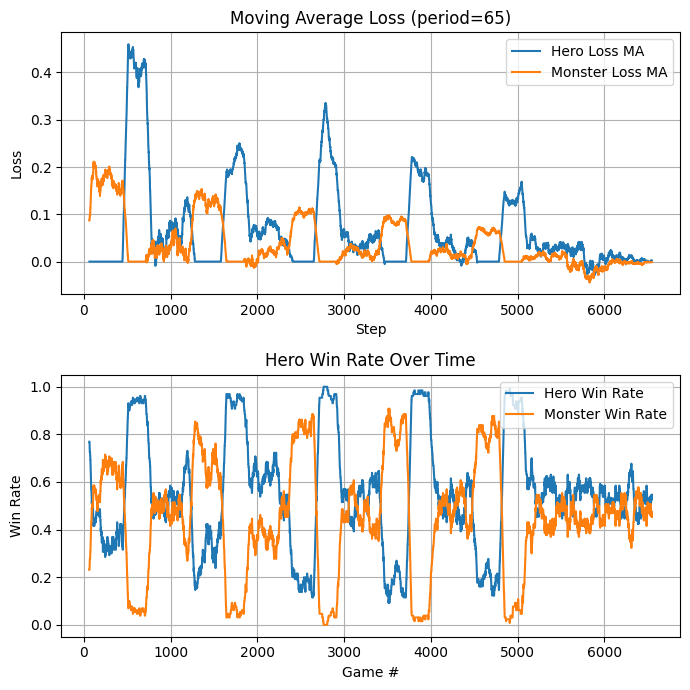

Saved PyTorch model to: /notebooks/ai_weights_hero.pth
Saved PyTorch model to: /notebooks/ai_weights_monster.pth


In [308]:
# !ls /  # Shows that you are connected to Paperspace cloud GPU
# Sometimes bugs occur from using a remote kernel.

hyperparameters = {
    # Network architecture:
    "rnn_size": 64,
    "num_rnn_layers": 2,  # Ignore dropout warning if X=1
    "feedforward_size": 64,
    # Reward shaping:
    "long_term_gamma": 0.95,  # Lower values decay the end-of-game reward to earlier turns faster
    "short_term_gamma": 0.7,
    "negative_reward_clamp": float('-inf'),  # Clamp negative rewards to this value to make them less punishing. All rewards below this value are set to this value (set to float('-inf') to disable)
    # Learning rate parameters (LR scheduler):
    "lr":1e-3,  # For 5 or more epochs, use 1e-4; for 1 epoch use 1e-3 (no scheduler)
    "use_lr_scheduler": True,  # lr scheduler (cosine annealing)
    "T_0": 500,  # lr cosine anneal period (repeats every X games with warm restarts)
    "T_mult": 1,  # Multiply T_0 by this factor every time it restarts (default is 1)
    "eta_min": 1e-6,  # Anneal from lr (above) to this lr
    # Misc. Parameters:
    "dropout_rate": 0.2,  # Randomly disables X% neurons during forward pass. Reduces overfitting, but too high a value adds a lot of noise to the loss.
    "weight_decay": 0.01,  # This is L2 regularization, adds a term to the loss calculation that punishes large weights.
    "epochs": 1,  # 1 epoch is much faster than multiple because the torch gradient isn't recomputed.
    "temperature": 2,  # Adds a degree of randomness to sample_action. Lower values are deterministic, higher values are random.
    "entropy_coef": 0.01  # Higher values slow down learning, increase exploration, and slow convergence.
}

game_settings = {
    # Training parameters:
    "training_hero_type": "computer_ai",
    "training_monster_type": "computer_ai",
    "training_display": False,
    "hero_training": True,
    "monster_training": True,
    "tempo_weight": 1.0,  # Non game-end rewards are multiplied by this value. Set to 0 to train only on game-end rewards (winning and losing).
    # Annealing:
    "anneal_temperature": False,
    "anneal_entropy": False,  # Linearly reduce entropy from entropy_coef to 0 over the course of training
    # Pooling parameters:
    "pool_size": 30,  # How many AI weights to keep in the pool for training
    "save_frequency": 30,
    # Testing parameters:
    "testing_best_of": 1,
    "testing_hero_type": "computer_ai",
    "testing_monster_type": "computer_ai",
    "testing_display": True,
    # Misc.:
    "scale": 100  # Lower values are *less* zoomed in
}

main = Main(hyperparameters, **game_settings)
main.load_ai_weights()

# Training program:
for i in range(5):
    print(f"\nRound {i+1}, FIGHT!")
    # Pretrain Monster on random Hero
    main.training_hero_type = "computer_random"
    main.training_monster_type = "computer_ai"
    main.train_on_wins("monster", 250)
    # Pretrain Hero on random Monster
    main.training_hero_type = "computer_ai"
    main.training_monster_type = "computer_random"
    main.train_on_wins("hero", 250)
    # Train Hero and Monster on a pool of their past opponents
    main.training_hero_type = "computer_ai"
    main.training_monster_type = "computer_ai"
    main.train_on_population(500, use_mcontrol=True)
    main.hero_ai.temperature /= 2
    main.monster_ai.temperature /= 2
    main.hero_ai.entropy_coef /= 2
    main.monster_ai.entropy_coef /= 2
    main.hero_ai.optimizer.param_groups[0]['lr'] /= 2
    main.monster_ai.optimizer.param_groups[0]['lr'] /= 2
# Post-train using game-end rewards as sole feedback
main.anneal_temperature = True
main.anneal_entropy = True
main.hero_ai.use_lr_scheduler = False
main.monster_ai.use_lr_scheduler = False
main.hero_ai.optimizer.param_groups[0]['lr'] = 1e-6
main.monster_ai.optimizer.param_groups[0]['lr'] = 1e-6
main.tempo_weight = 0.0  # Important
main.train_on_population(1000, use_mcontrol=True)
# After training, test the AI against each other
main.hero_training = False
main.monster_training = False
main.hero_ai.temperature = 0.0001
main.monster_ai.temperature = 0.0001
main.do_testing_loop(1)
main.plot_graphs()
main.save_ai_weights()
# If using Paperspace, weights will be saved to the cloud

# jupyter nbconvert --to script --no-prompt --output poker_monster "Poker Monster - With Documentation.ipynb" 